# **Sentiment Analysis for IMDb movies 🍿👀📽**

In this project, I perform sentiment analysis on IMDb movies' reviews. The inputs to my model are **GloVe word embeddings**. I classify the reviews into two classes (Positive and Negative) using a **bidirectional stacked RNNs** with **LSTM/GRU** experimenting with several parameters.

---



In [ ]:
#for module torchtext.legacy
!pip install torchtext==0.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 MB 2.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0+cu116
    Uninstalling torch-1.13.0+cu116:
      Successfully uninstalled torch-1.13.0+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.0
    Uninstalling torchtext-0.14.0:
      Successfully uninstalled torchtext-0.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.0+cu116 requires torch==1.13.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.13.0+cu116 requires torch==1.13.0, but you have torch 1.8.0 which is incompatible.


In [ ]:
#for resolving RuntimeError: cuDNN error: CUDNN_STATUS_NOT_INITIALIZED
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 GB 46.1 MB/s eta 0:00:01tcmalloc: large alloc 1982242816 bytes == 0x3916000 @  0x7f152b7c11e7 0x4d30a0 0x4d312c 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x5d8868 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4997a2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 2.0/2.0 GB 45.4 MB/s eta 0:00:01tcmalloc: large alloc 2477809664 bytes == 0x79b80000 @  0x7f152b7c2615 0x5d6f4c 0x51edd1 0x51ef5b 0x4f750a 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d8941 0x4997a2 0x5d8868 0x4997a2 0x55cd91 0x5d8941 0x49abe4 0x55cd91 0x5d8941 0x4997a2 0x55cd91 0x5d

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

## **Load the dataset** 

For **testing** the model give to **TESTING_DATA_PATH** variable the path where the file with testing data is located

In [ ]:
TESTING_DATA_PATH=""
DATA_PATH=""

In [ ]:
if not DATA_PATH:
  drive.mount('/content/drive')
  DATA_PATH = "/content/drive/MyDrive/AI_2_exercise_1_data/imdb-reviews.csv"
df = pd.read_csv(filepath_or_buffer=DATA_PATH, sep='\t')

if TESTING_DATA_PATH:
  # test_df = df.copy()
  # test_df = test_df.iloc[36006:45009]
  test_df = pd.read_csv(file_or_buffer=TESTING_DATA_PATH, sep='\t')

Mounted at /content/drive


A look at our data

In [ ]:
if not TESTING_DATA_PATH:
  print(f"Dataset shape: {df.shape}")
  pd.set_option('display.max_colwidth', 1000)
  df.head()

Dataset shape: (45008, 3)


Convert the sentiments as following:

* POS → 0
* NEG → 1

In [ ]:
 df.loc[df['rating'] < 5, ['rating']] = 0
 df.loc[df['rating'] > 6, ['rating']] = 1
 if TESTING_DATA_PATH:
   test_df.loc[test_df['rating'] < 5, ['rating']] = 0
   test_df.loc[test_df['rating'] > 6, ['rating']] = 1

## **Data pre-processing**

In order to aply logistic regression in the data, they must first be pre-processed.

### **Text Transformation**

In [ ]:
df.drop('url', inplace=True, axis=1)
if TESTING_DATA_PATH:
  test_df.drop('url', inplace=True, axis=1)

In [ ]:
if not TESTING_DATA_PATH:
  print(df.isnull().sum())

rating    0
review    0
dtype: int64


We detect no missing values in the dataset

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

nltk.download('stopwords')

# Define the function for text transformation
def text_transformation(text):
  # Lower characters
  text = text.lower()
  # Remove links
  text = re.sub('http://\S+|https://\S+', '', text)
  # Remove non letter characters
  text = re.sub(r'[^A-Za-z]+', ' ', text)
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove stopwords
  StopWords = stopwords.words("english")
  text = ' '.join([word for word in text.split() if word not in StopWords])
  # Lemmatization
  snow_stemmer = SnowballStemmer(language='english')
  text = ' '.join([snow_stemmer.stem(word) for word in text.split()])
  
  return text  

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df['review'] = df['review'].apply(text_transformation)
if TESTING_DATA_PATH:
  test_df['review'] = test_df['review'].apply(text_transformation)


In [ ]:
df.head()

,rating,review
0,1.0,thought quiet good movi fun watch like best outtak end movi great
1,1.0,wagon master uniqu film amongst john ford work main one base stori written john ford stori elabor frank nugent director son patrick ford turn screenplay director person opinion regard wagon master film john ford call one came closest want achiev say say littl ford confess lindsay anderson favourit nonetheless darl clementin br br wagon master ingredi one might expect find john ford film wonder cast deliv best thou featur major star except fordian actor ben johnson peculiar small charact provid obligatori comic relief wagon master quit horn blow sister ledyard jane darwel shot inspir gig last least legendari monument valley john ford fifth passag stagecoach darl clementin fort apach wore yellow ribbon br br film start two friend cowboy travi blue ben johnson sandi owen harri carey jr hire wagon master guid caravan mormon settler head silver valley place like promis land way join peculiar dr locksley hall alan mowbray two beauti women suppos wife daughter call actor head direct simpl...
2,1.0,film near perfect film john ford made film magic masterpiec reason ford well ford want know ford great one explain br br photographi cours superb black white black white wonder shot shoulder convers pure ford great moment big littl famous rip pant ward bond appar two dog kept invad set fight ford want use fight scene instead fight one dog ran away attack ward bond rip pant caus ford end mirth whole scene around plait rope way ben johnson burn snuff rope wonder foreshadow anticip final harri carey naiv court prudenc usual ford line scare show bond hors accident fall left film johnson bond fantast scene lord help ford actor stay charact camera roll even hors fall top br br coupl sweet romanc intrud whole focus two likabl lead mention girl number time camera focus ben johnson rather delight backsid br br lot old time stuntmen get line role cliff lyon frank mcgrath wonder charact studi most face stare villain main star set villain rival group western br br mani mani fordian shot face g...
3,0.0,gave star lot interest theme mani alreadi mention domest violenc sexual mani taboo therein outsid gore realli would call horror much would scienc fiction br br bleak depress hopeless mind less cheeri end realli tire human suck clich central everi movi know get liber art degre today without bow alter self hatr member human race bout writer director pretend differ everyon els pack notic alien kill human race evil right read believ human deserv die go find lake swim til arm tire way around direct next film write next book tell deserv die aliv silli thought bore
4,1.0,movi realli genuin random realli hard find movi like bunch movi hollywood realli enjoy watch movi bought dvd tuesday week watch time love spanglish accent paz realli cute act morgan funni natur br br movi tast might realli differ other say realli love movi simpl best br br learn someth life movi well least usa life life realli random sometim u meet someon pass life friend coincid u spend much time mayb u enjoy u never meet time u togeth realli unforgett keep moment mind grate nice memori br br movi might cheap make price mean total cheap rare learn anyth movi except


### **Train Test split**

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


Save datasets in csv format for the TabularDataset

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)
if not TESTING_DATA_PATH:
  train, val = train_test_split(train, test_size=0.2, random_state=42)
  val.to_csv("/content/drive/MyDrive/valid.csv", index=False)
if TESTING_DATA_PATH:
  test = test_df

train.to_csv("/content/drive/MyDrive/train.csv", index=False)
test.to_csv("/content/drive/MyDrive/test.csv", index=False)

### **Field objects**

In [ ]:
import torchtext
from torchtext.legacy import data

#We are using the SpaCy tokenizer.
#include_lengths = True so as to khow the length
#of the sequences to use packed padded sequences
REVIEW = torchtext.legacy.data.Field(tokenize = "spacy", include_lengths = True)

RATING = data.LabelField(dtype=torch.float)

/usr/local/lib/python3.8/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


Importing the data with TabularDataset

In [ ]:
if not TESTING_DATA_PATH:
  train_data, valid_data, test_data = data.TabularDataset.splits(
      path = "/content/drive/MyDrive/", 
      train = "train.csv", 
      validation = "valid.csv", 
      test = "test.csv",
      format = "csv", 
      skip_header = True, 
      fields = [('rating', RATING), ('review', REVIEW)]
  )
else:
  train_data, test_data = data.TabularDataset.splits(
      path = "/content/drive/MyDrive/", 
      train = "train.csv", 
      test = "test.csv",
      format = "csv", 
      skip_header = True, 
      fields = [('rating', RATING), ('review', REVIEW)]
  )

Each row has text and label field

In [ ]:
print(train_data[0].review)
print(train_data[0].rating)

['back', 'matthew', 'lawrenc', 'hot', 'chick', 'also', 'saw', 'drumlin', 'day', 'drumlin', 'win', 'default', 'comebcak', 'releas', 'march', 'plan', 'time', 'tmnt', 'releas', 'tmnt', 'would', 'default', 'br', 'br', 'grant', 'matthew', 'lawrenc', 'fine', 'job', 'portray', 'quarterback', 'resort', 'utter', 'dirti', 'word', 'plus', 'start', 'play', 'privat', 'part', 'well', 'anoth', 'footbal', 'player', 'touch', 'girl', 'boob', 'minus', 'br', 'br', 'biggest', 'minus', 'tick', 'everi', 'footbal', 'player', 'got', 'particip', 'mock', 'music', 'video', 'except', 'matthew', 'lawrenc', 'insert', 'price', 'right', 'lose', 'horn', 'anoth', 'blown', 'music', 'opportun', 'shi', 'music', 'br', 'br', 'past', 'matt', 'disappoint', 'mani', 'time', 'super', 'human', 'samurai', 'syber', 'squad', 'came', 'close', 'music', 'moment', 'end', 'fail', 'br', 'br', 'sure', 'joey', 'sing', 'career', 'two', 'album', 'belt', 'andrew', 'start', 'music', 'career', 'rare', 'find', 'matt', 'music', 'moment', 'two', 'st

### **GloVe**

Mapping all the unique words (defined by max_size parameter) to the corresponding GloVe word embedding.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-01-15 15:56:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-15 15:56:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-15 15:56:07--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

By default, TorchText will initialize words in our vocabulary but not in our pre-trained embeddings to zero. We don't want this, and instead initialize them randomly by setting unk_init = torch.Tensor.normal_. This will now initialize those words via a Gaussian distribution.

In [ ]:
GloVe_path = '/content/glove.6B.50d.txt'
MAX_VOCAB_SIZE = 20000

REVIEW.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors=torchtext.vocab.Vectors(GloVe_path), 
                 unk_init = torch.Tensor.normal_)

RATING.build_vocab(train_data)

100%|█████████▉| 399999/400000 [00:07<00:00, 50434.46it/s]


In [ ]:
BATCH_SIZE = 256

if not TESTING_DATA_PATH:
  #We sort all the tensors in a batch by their lengths
  train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, valid_data, test_data), 
      batch_size = BATCH_SIZE, 
      sort_within_batch = True,
      sort_key = lambda x: len(x.review,),
      device = device)
else:
  train_iterator, test_iterator = data.BucketIterator.splits(
      (train_data, test_data), 
      batch_size = BATCH_SIZE, 
      sort_within_batch = True,
      sort_key = lambda x: len(x.review,),
      device = device)

## **BRNN**

### Initializing BRNN class

- We pass the index of our <pad> token as the padding_idx argument to the nn.Embedding layer, in order not to  to learn the embedding for the <pad> token.
- We get the top two hidden layers from the first dimension, hidden[-2,:,:] and hidden[-1,:,:], and concatenate them together before passing them to the linear layer (after applying dropout), to get the final (top) layer forward and backward hidden states, . 

In [ ]:
import torch.nn as nn

class BRNN(nn.Module):
    def __init__(self, cell_type, vocab_size, embedding_dim, hidden_dim, 
                 output_dim, n_layers, dropout, pad_idx):
      
        super(BRNN, self).__init__()
        
        cells = {
            "LSTM" : nn.LSTM,
            "GRU"  : nn.GRU
        }
        
        self.cell_type = cell_type
        self.input_dim = vocab_size 
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        #RNN layer
        self.rnn = cells[cell_type](embedding_dim, 
                                    hidden_dim, 
                                    num_layers = n_layers, 
                                    bidirectional = True, 
                                    dropout = dropout)
        
        #Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        #Output layer
        self.out = nn.Linear(hidden_dim * 2, output_dim)

        #Sigmoid activation function layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, text_length):
                
        embedded_text = self.dropout(self.embedding(text))
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded_text, text_length.to('cpu'))

        if self.cell_type == 'LSTM':
          output, (hidden, _) = self.rnn(packed_embedded)
        else:
          output, hidden = self.rnn(packed_embedded)

        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)

        return self.sigmoid(self.out(self.dropout(hidden)))

In [ ]:
def get_accuracy(y_true, y_pred):
  y_pred = torch.round(y_pred)
  correct = (y_true == y_pred).float() 
  accuracy = correct.sum() / len(correct)
  return accuracy

### Training and evaluating functions

In [ ]:
#train the model on the training dataset
#returns epoch loss and accuracy
def train(model, iterator, optimizer, criterion, clip_value = 5):
    
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for batch in iterator:
      optimizer.zero_grad()
      text, text_length = batch.review      
      pred = model(text, text_length).squeeze(1)
      loss = criterion(pred, batch.rating)
      acc = get_accuracy(batch.rating, pred)
      
      loss.backward()

      # Clip gradients
      torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

      optimizer.step()
      
      epoch_loss += loss.item()
      epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#evaluates the model on the validation dataset
#returns epoch loss and accuracy
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_length = batch.review
            pred = model(text, text_length).squeeze(1)
            loss = criterion(pred, batch.rating)
            acc = get_accuracy(batch.rating, pred)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

###Choosing hyperparameters

In [ ]:
if not TESTING_DATA_PATH:
  %pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 15.0 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=26da65a41686411914fed6b2b0ba27c48d603cae2a42b91963d64523e336d0fb
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  

An open source hyperparameter optimization framework to automate hyperparameter search. We experiment with cell type, hidden dimension, number of layers, dropout value, clip value, number of epochs maximizing the accuracy of the model

In [ ]:
if not TESTING_DATA_PATH:
  import optuna
  import torch.optim as optim

  #An objective function to be maximized.
  def objective(trial):
    CELL_TYPE = trial.suggest_categorical('CELL_TYPE', ['LSTM', 'GRU'])
    INPUT_DIM = len(REVIEW.vocab)
    EMBEDDING_DIM = 50
    HIDDEN_DIM =  trial.suggest_categorical('HIDDEN_DIM', [32, 64, 128])
    OUTPUT_DIM = 1
    N_LAYERS = trial.suggest_int('N_LAYERS', 2, 3)
    DROPOUT = trial.suggest_float('DROPOUT', 0, 1)
    PAD_IDX = REVIEW.vocab.stoi[REVIEW.pad_token]

    model = BRNN(CELL_TYPE, 
                  INPUT_DIM, 
                  EMBEDDING_DIM, 
                  HIDDEN_DIM, 
                  OUTPUT_DIM, 
                  N_LAYERS, 
                  DROPOUT, 
                  PAD_IDX)

    pretrained_embeddings = REVIEW.vocab.vectors

    # replace the initial weights of the embedding layer with the GloVe pre-trained embeddings.
    model.embedding.weight.data.copy_(pretrained_embeddings)

    # find the index of <unk> token in our vocabulary
    UNK_IDX = REVIEW.vocab.stoi[REVIEW.unk_token]

    # initialize the <unk> and <pad> tokens to zero
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCELoss()
    model = model.to(device)
    criterion = criterion.to(device)

    N_EPOCHS = trial.suggest_int('N_EPOCHS', 5, 15)
    CLIP_VALUE = trial.suggest_int('CLIP_VALUE', 1, 5)

    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, CLIP_VALUE)
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
            
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    return valid_acc

  #A study object to optimize the objective function.
  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=50)

[I 2023-01-15 15:59:26,282] A new study created in memory with name: no-name-d9f3eac1-eb55-40e0-9431-77b8d1b0aecf


Epoch: 01
	Train Loss: 0.552 | Train Acc: 70.34%
	 Val. Loss: 0.408 |  Val. Acc: 82.71%
Epoch: 02
	Train Loss: 0.352 | Train Acc: 84.91%
	 Val. Loss: 0.314 |  Val. Acc: 86.54%
Epoch: 03
	Train Loss: 0.266 | Train Acc: 89.13%
	 Val. Loss: 0.276 |  Val. Acc: 88.68%
Epoch: 04
	Train Loss: 0.230 | Train Acc: 90.87%
	 Val. Loss: 0.283 |  Val. Acc: 88.93%


[I 2023-01-15 16:00:45,976] Trial 0 finished with value: 0.8932397303910091 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 128, 'N_LAYERS': 3, 'DROPOUT': 0.07541046236432003, 'N_EPOCHS': 5, 'CLIP_VALUE': 5}. Best is trial 0 with value: 0.8932397303910091.


Epoch: 05
	Train Loss: 0.185 | Train Acc: 93.00%
	 Val. Loss: 0.301 |  Val. Acc: 89.32%
Epoch: 01
	Train Loss: 0.608 | Train Acc: 65.32%
	 Val. Loss: 0.460 |  Val. Acc: 79.41%
Epoch: 02
	Train Loss: 0.451 | Train Acc: 79.12%
	 Val. Loss: 0.354 |  Val. Acc: 84.37%
Epoch: 03
	Train Loss: 0.366 | Train Acc: 84.37%
	 Val. Loss: 0.299 |  Val. Acc: 87.38%
Epoch: 04
	Train Loss: 0.319 | Train Acc: 86.64%
	 Val. Loss: 0.269 |  Val. Acc: 89.22%
Epoch: 05
	Train Loss: 0.284 | Train Acc: 88.37%
	 Val. Loss: 0.279 |  Val. Acc: 88.54%
Epoch: 06
	Train Loss: 0.262 | Train Acc: 89.13%
	 Val. Loss: 0.312 |  Val. Acc: 86.89%


[I 2023-01-15 16:01:26,384] Trial 1 finished with value: 0.9026686097013539 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.4950486840764762, 'N_EPOCHS': 7, 'CLIP_VALUE': 4}. Best is trial 1 with value: 0.9026686097013539.


Epoch: 07
	Train Loss: 0.238 | Train Acc: 90.30%
	 Val. Loss: 0.252 |  Val. Acc: 90.27%
Epoch: 01
	Train Loss: 0.660 | Train Acc: 59.18%
	 Val. Loss: 0.539 |  Val. Acc: 73.76%
Epoch: 02
	Train Loss: 0.518 | Train Acc: 74.85%
	 Val. Loss: 0.432 |  Val. Acc: 80.35%
Epoch: 03
	Train Loss: 0.422 | Train Acc: 81.15%
	 Val. Loss: 0.341 |  Val. Acc: 85.51%
Epoch: 04
	Train Loss: 0.361 | Train Acc: 84.52%
	 Val. Loss: 0.319 |  Val. Acc: 87.09%
Epoch: 05
	Train Loss: 0.331 | Train Acc: 86.25%
	 Val. Loss: 0.299 |  Val. Acc: 88.26%
Epoch: 06
	Train Loss: 0.297 | Train Acc: 87.90%
	 Val. Loss: 0.286 |  Val. Acc: 88.58%
Epoch: 07
	Train Loss: 0.273 | Train Acc: 88.87%
	 Val. Loss: 0.265 |  Val. Acc: 89.48%
Epoch: 08
	Train Loss: 0.252 | Train Acc: 89.85%
	 Val. Loss: 0.273 |  Val. Acc: 89.41%
Epoch: 09
	Train Loss: 0.241 | Train Acc: 90.53%
	 Val. Loss: 0.289 |  Val. Acc: 88.56%
Epoch: 10
	Train Loss: 0.224 | Train Acc: 91.08%
	 Val. Loss: 0.257 |  Val. Acc: 90.26%
Epoch: 11
	Train Loss: 0.211 | T

[I 2023-01-15 16:02:42,027] Trial 2 finished with value: 0.9058459051724138 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.5267170200734055, 'N_EPOCHS': 15, 'CLIP_VALUE': 3}. Best is trial 2 with value: 0.9058459051724138.


Epoch: 15
	Train Loss: 0.178 | Train Acc: 93.19%
	 Val. Loss: 0.280 |  Val. Acc: 90.58%
Epoch: 01
	Train Loss: 0.593 | Train Acc: 67.19%
	 Val. Loss: 0.449 |  Val. Acc: 79.48%
Epoch: 02
	Train Loss: 0.442 | Train Acc: 79.92%
	 Val. Loss: 0.357 |  Val. Acc: 84.23%
Epoch: 03
	Train Loss: 0.366 | Train Acc: 84.24%
	 Val. Loss: 0.317 |  Val. Acc: 86.81%
Epoch: 04
	Train Loss: 0.309 | Train Acc: 87.02%
	 Val. Loss: 0.300 |  Val. Acc: 88.04%
Epoch: 05
	Train Loss: 0.284 | Train Acc: 88.19%
	 Val. Loss: 0.261 |  Val. Acc: 89.47%
Epoch: 06
	Train Loss: 0.253 | Train Acc: 89.60%
	 Val. Loss: 0.301 |  Val. Acc: 88.95%
Epoch: 07
	Train Loss: 0.235 | Train Acc: 90.46%
	 Val. Loss: 0.265 |  Val. Acc: 89.63%
Epoch: 08
	Train Loss: 0.226 | Train Acc: 90.89%
	 Val. Loss: 0.249 |  Val. Acc: 90.20%


[I 2023-01-15 16:04:31,342] Trial 3 finished with value: 0.884547730972027 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 128, 'N_LAYERS': 3, 'DROPOUT': 0.4764704501067334, 'N_EPOCHS': 9, 'CLIP_VALUE': 4}. Best is trial 2 with value: 0.9058459051724138.


Epoch: 09
	Train Loss: 0.206 | Train Acc: 91.81%
	 Val. Loss: 0.298 |  Val. Acc: 88.45%
Epoch: 01
	Train Loss: 0.651 | Train Acc: 61.00%
	 Val. Loss: 0.536 |  Val. Acc: 73.93%
Epoch: 02
	Train Loss: 0.525 | Train Acc: 74.30%
	 Val. Loss: 0.527 |  Val. Acc: 79.02%
Epoch: 03
	Train Loss: 0.453 | Train Acc: 79.45%
	 Val. Loss: 0.476 |  Val. Acc: 81.29%
Epoch: 04
	Train Loss: 0.398 | Train Acc: 82.49%
	 Val. Loss: 0.415 |  Val. Acc: 85.13%
Epoch: 05
	Train Loss: 0.358 | Train Acc: 84.72%
	 Val. Loss: 0.426 |  Val. Acc: 84.72%
Epoch: 06
	Train Loss: 0.338 | Train Acc: 85.91%
	 Val. Loss: 0.346 |  Val. Acc: 87.90%
Epoch: 07
	Train Loss: 0.313 | Train Acc: 87.06%
	 Val. Loss: 0.375 |  Val. Acc: 86.62%
Epoch: 08
	Train Loss: 0.301 | Train Acc: 87.55%
	 Val. Loss: 0.385 |  Val. Acc: 86.14%
Epoch: 09
	Train Loss: 0.288 | Train Acc: 88.29%
	 Val. Loss: 0.365 |  Val. Acc: 88.04%


[I 2023-01-15 16:05:33,166] Trial 4 finished with value: 0.8869009881184019 and parameters: {'CELL_TYPE': 'LSTM', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.6605847097548111, 'N_EPOCHS': 10, 'CLIP_VALUE': 1}. Best is trial 2 with value: 0.9058459051724138.


Epoch: 10
	Train Loss: 0.271 | Train Acc: 89.21%
	 Val. Loss: 0.344 |  Val. Acc: 88.69%
Epoch: 01
	Train Loss: 0.694 | Train Acc: 50.38%
	 Val. Loss: 0.691 |  Val. Acc: 50.61%
Epoch: 02
	Train Loss: 0.678 | Train Acc: 55.97%
	 Val. Loss: 0.563 |  Val. Acc: 71.55%
Epoch: 03
	Train Loss: 0.637 | Train Acc: 65.04%
	 Val. Loss: 0.542 |  Val. Acc: 72.87%
Epoch: 04
	Train Loss: 0.590 | Train Acc: 69.67%
	 Val. Loss: 0.553 |  Val. Acc: 73.57%
Epoch: 05
	Train Loss: 0.545 | Train Acc: 73.19%
	 Val. Loss: 0.523 |  Val. Acc: 77.90%
Epoch: 06
	Train Loss: 0.517 | Train Acc: 75.12%
	 Val. Loss: 0.544 |  Val. Acc: 78.62%
Epoch: 07
	Train Loss: 0.486 | Train Acc: 77.64%
	 Val. Loss: 0.418 |  Val. Acc: 84.29%
Epoch: 08
	Train Loss: 0.446 | Train Acc: 79.72%
	 Val. Loss: 0.522 |  Val. Acc: 82.02%


[I 2023-01-15 16:06:51,179] Trial 5 finished with value: 0.8094970213955847 and parameters: {'CELL_TYPE': 'LSTM', 'HIDDEN_DIM': 64, 'N_LAYERS': 3, 'DROPOUT': 0.8603796226236731, 'N_EPOCHS': 9, 'CLIP_VALUE': 3}. Best is trial 2 with value: 0.9058459051724138.


Epoch: 09
	Train Loss: 0.433 | Train Acc: 80.72%
	 Val. Loss: 0.607 |  Val. Acc: 80.95%
Epoch: 01
	Train Loss: 0.693 | Train Acc: 51.30%
	 Val. Loss: 0.681 |  Val. Acc: 62.47%
Epoch: 02
	Train Loss: 0.655 | Train Acc: 61.95%
	 Val. Loss: 0.569 |  Val. Acc: 71.80%
Epoch: 03
	Train Loss: 0.586 | Train Acc: 70.22%
	 Val. Loss: 0.495 |  Val. Acc: 77.07%
Epoch: 04
	Train Loss: 0.539 | Train Acc: 73.80%
	 Val. Loss: 0.437 |  Val. Acc: 80.90%
Epoch: 05
	Train Loss: 0.490 | Train Acc: 77.36%
	 Val. Loss: 0.413 |  Val. Acc: 83.36%
Epoch: 06
	Train Loss: 0.443 | Train Acc: 80.01%
	 Val. Loss: 0.382 |  Val. Acc: 83.94%


[I 2023-01-15 16:07:26,173] Trial 6 finished with value: 0.8646123861444408 and parameters: {'CELL_TYPE': 'LSTM', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.7638026210026725, 'N_EPOCHS': 7, 'CLIP_VALUE': 4}. Best is trial 2 with value: 0.9058459051724138.


Epoch: 07
	Train Loss: 0.417 | Train Acc: 81.69%
	 Val. Loss: 0.356 |  Val. Acc: 86.46%
Epoch: 01
	Train Loss: 0.679 | Train Acc: 56.46%
	 Val. Loss: 0.621 |  Val. Acc: 62.35%
Epoch: 02
	Train Loss: 0.608 | Train Acc: 67.56%
	 Val. Loss: 0.525 |  Val. Acc: 76.51%
Epoch: 03
	Train Loss: 0.558 | Train Acc: 72.08%
	 Val. Loss: 0.471 |  Val. Acc: 77.07%
Epoch: 04
	Train Loss: 0.506 | Train Acc: 75.88%
	 Val. Loss: 0.412 |  Val. Acc: 82.30%
Epoch: 05
	Train Loss: 0.459 | Train Acc: 78.92%
	 Val. Loss: 0.468 |  Val. Acc: 79.47%
Epoch: 06
	Train Loss: 0.428 | Train Acc: 80.60%
	 Val. Loss: 0.464 |  Val. Acc: 80.23%
Epoch: 07
	Train Loss: 0.397 | Train Acc: 82.36%
	 Val. Loss: 0.370 |  Val. Acc: 85.21%
Epoch: 08
	Train Loss: 0.375 | Train Acc: 83.63%
	 Val. Loss: 0.302 |  Val. Acc: 87.53%
Epoch: 09
	Train Loss: 0.359 | Train Acc: 84.58%
	 Val. Loss: 0.353 |  Val. Acc: 87.13%
Epoch: 10
	Train Loss: 0.335 | Train Acc: 85.59%
	 Val. Loss: 0.417 |  Val. Acc: 84.86%


[I 2023-01-15 16:08:51,706] Trial 7 finished with value: 0.8785496950149536 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 128, 'N_LAYERS': 2, 'DROPOUT': 0.8148093864210177, 'N_EPOCHS': 11, 'CLIP_VALUE': 5}. Best is trial 2 with value: 0.9058459051724138.


Epoch: 11
	Train Loss: 0.325 | Train Acc: 86.26%
	 Val. Loss: 0.344 |  Val. Acc: 87.85%
Epoch: 01
	Train Loss: 0.611 | Train Acc: 65.02%
	 Val. Loss: 0.458 |  Val. Acc: 78.41%
Epoch: 02
	Train Loss: 0.403 | Train Acc: 82.03%
	 Val. Loss: 0.328 |  Val. Acc: 86.41%
Epoch: 03
	Train Loss: 0.316 | Train Acc: 86.58%
	 Val. Loss: 0.283 |  Val. Acc: 88.63%
Epoch: 04
	Train Loss: 0.264 | Train Acc: 89.27%
	 Val. Loss: 0.276 |  Val. Acc: 88.84%
Epoch: 05
	Train Loss: 0.238 | Train Acc: 90.54%
	 Val. Loss: 0.267 |  Val. Acc: 89.50%
Epoch: 06
	Train Loss: 0.207 | Train Acc: 91.98%
	 Val. Loss: 0.253 |  Val. Acc: 89.98%
Epoch: 07
	Train Loss: 0.188 | Train Acc: 92.73%
	 Val. Loss: 0.270 |  Val. Acc: 89.95%
Epoch: 08
	Train Loss: 0.172 | Train Acc: 93.41%
	 Val. Loss: 0.278 |  Val. Acc: 90.07%
Epoch: 09
	Train Loss: 0.156 | Train Acc: 94.14%
	 Val. Loss: 0.282 |  Val. Acc: 90.15%
Epoch: 10
	Train Loss: 0.145 | Train Acc: 94.63%
	 Val. Loss: 0.277 |  Val. Acc: 90.28%
Epoch: 11
	Train Loss: 0.130 | T

[I 2023-01-15 16:09:57,013] Trial 8 finished with value: 0.8954028281672247 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.27332497907332587, 'N_EPOCHS': 13, 'CLIP_VALUE': 4}. Best is trial 2 with value: 0.9058459051724138.


Epoch: 13
	Train Loss: 0.117 | Train Acc: 95.68%
	 Val. Loss: 0.323 |  Val. Acc: 89.54%
Epoch: 01
	Train Loss: 0.722 | Train Acc: 50.06%
	 Val. Loss: 0.693 |  Val. Acc: 52.37%
Epoch: 02
	Train Loss: 0.700 | Train Acc: 50.03%
	 Val. Loss: 0.693 |  Val. Acc: 54.93%
Epoch: 03
	Train Loss: 0.695 | Train Acc: 50.42%
	 Val. Loss: 0.693 |  Val. Acc: 53.98%
Epoch: 04
	Train Loss: 0.694 | Train Acc: 50.50%
	 Val. Loss: 0.693 |  Val. Acc: 54.32%


[I 2023-01-15 16:10:31,835] Trial 9 finished with value: 0.5075431034482759 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 3, 'DROPOUT': 0.8843057202997832, 'N_EPOCHS': 5, 'CLIP_VALUE': 2}. Best is trial 2 with value: 0.9058459051724138.


Epoch: 05
	Train Loss: 0.694 | Train Acc: 49.94%
	 Val. Loss: 0.693 |  Val. Acc: 50.75%
Epoch: 01
	Train Loss: 0.617 | Train Acc: 64.84%
	 Val. Loss: 0.464 |  Val. Acc: 79.00%
Epoch: 02
	Train Loss: 0.434 | Train Acc: 80.52%
	 Val. Loss: 0.348 |  Val. Acc: 84.90%
Epoch: 03
	Train Loss: 0.335 | Train Acc: 85.98%
	 Val. Loss: 0.298 |  Val. Acc: 87.82%
Epoch: 04
	Train Loss: 0.284 | Train Acc: 88.37%
	 Val. Loss: 0.321 |  Val. Acc: 86.18%
Epoch: 05
	Train Loss: 0.246 | Train Acc: 90.10%
	 Val. Loss: 0.270 |  Val. Acc: 89.38%
Epoch: 06
	Train Loss: 0.224 | Train Acc: 91.02%
	 Val. Loss: 0.256 |  Val. Acc: 89.96%
Epoch: 07
	Train Loss: 0.205 | Train Acc: 91.99%
	 Val. Loss: 0.257 |  Val. Acc: 90.13%
Epoch: 08
	Train Loss: 0.184 | Train Acc: 93.01%
	 Val. Loss: 0.271 |  Val. Acc: 89.57%
Epoch: 09
	Train Loss: 0.167 | Train Acc: 93.64%
	 Val. Loss: 0.308 |  Val. Acc: 89.17%
Epoch: 10
	Train Loss: 0.155 | Train Acc: 94.03%
	 Val. Loss: 0.273 |  Val. Acc: 90.25%
Epoch: 11
	Train Loss: 0.145 | T

[I 2023-01-15 16:11:47,145] Trial 10 finished with value: 0.8965438008308411 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.315557522548795, 'N_EPOCHS': 15, 'CLIP_VALUE': 2}. Best is trial 2 with value: 0.9058459051724138.


Epoch: 15
	Train Loss: 0.112 | Train Acc: 95.89%
	 Val. Loss: 0.320 |  Val. Acc: 89.65%
Epoch: 01
	Train Loss: 0.625 | Train Acc: 63.99%
	 Val. Loss: 0.487 |  Val. Acc: 77.70%
Epoch: 02
	Train Loss: 0.473 | Train Acc: 78.25%
	 Val. Loss: 0.409 |  Val. Acc: 82.49%
Epoch: 03
	Train Loss: 0.388 | Train Acc: 82.83%
	 Val. Loss: 0.312 |  Val. Acc: 87.28%
Epoch: 04
	Train Loss: 0.332 | Train Acc: 86.07%
	 Val. Loss: 0.292 |  Val. Acc: 88.35%
Epoch: 05
	Train Loss: 0.298 | Train Acc: 87.83%
	 Val. Loss: 0.269 |  Val. Acc: 89.16%
Epoch: 06
	Train Loss: 0.274 | Train Acc: 88.64%
	 Val. Loss: 0.281 |  Val. Acc: 89.41%
Epoch: 07
	Train Loss: 0.255 | Train Acc: 89.74%
	 Val. Loss: 0.257 |  Val. Acc: 89.87%
Epoch: 08
	Train Loss: 0.234 | Train Acc: 90.48%
	 Val. Loss: 0.253 |  Val. Acc: 90.25%
Epoch: 09
	Train Loss: 0.219 | Train Acc: 91.38%
	 Val. Loss: 0.261 |  Val. Acc: 89.97%
Epoch: 10
	Train Loss: 0.210 | Train Acc: 91.88%
	 Val. Loss: 0.277 |  Val. Acc: 89.84%
Epoch: 11
	Train Loss: 0.200 | T

[I 2023-01-15 16:13:10,602] Trial 11 finished with value: 0.9070502663480824 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.5280268378151399, 'N_EPOCHS': 15, 'CLIP_VALUE': 3}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 15
	Train Loss: 0.167 | Train Acc: 93.61%
	 Val. Loss: 0.276 |  Val. Acc: 90.71%
Epoch: 01
	Train Loss: 0.644 | Train Acc: 61.50%
	 Val. Loss: 0.523 |  Val. Acc: 75.61%
Epoch: 02
	Train Loss: 0.514 | Train Acc: 75.30%
	 Val. Loss: 0.421 |  Val. Acc: 82.39%
Epoch: 03
	Train Loss: 0.430 | Train Acc: 80.77%
	 Val. Loss: 0.341 |  Val. Acc: 85.65%
Epoch: 04
	Train Loss: 0.372 | Train Acc: 83.97%
	 Val. Loss: 0.385 |  Val. Acc: 83.33%
Epoch: 05
	Train Loss: 0.331 | Train Acc: 86.12%
	 Val. Loss: 0.291 |  Val. Acc: 88.06%
Epoch: 06
	Train Loss: 0.310 | Train Acc: 87.12%
	 Val. Loss: 0.270 |  Val. Acc: 89.07%
Epoch: 07
	Train Loss: 0.286 | Train Acc: 88.24%
	 Val. Loss: 0.261 |  Val. Acc: 89.76%
Epoch: 08
	Train Loss: 0.268 | Train Acc: 89.13%
	 Val. Loss: 0.293 |  Val. Acc: 88.47%
Epoch: 09
	Train Loss: 0.252 | Train Acc: 89.77%
	 Val. Loss: 0.303 |  Val. Acc: 88.88%
Epoch: 10
	Train Loss: 0.239 | Train Acc: 90.33%
	 Val. Loss: 0.265 |  Val. Acc: 90.35%
Epoch: 11
	Train Loss: 0.232 | T

[I 2023-01-15 16:14:33,885] Trial 12 finished with value: 0.8992377663480824 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.6189647553601262, 'N_EPOCHS': 15, 'CLIP_VALUE': 3}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 15
	Train Loss: 0.193 | Train Acc: 92.40%
	 Val. Loss: 0.283 |  Val. Acc: 89.92%
Epoch: 01
	Train Loss: 0.582 | Train Acc: 68.08%
	 Val. Loss: 0.447 |  Val. Acc: 80.24%
Epoch: 02
	Train Loss: 0.395 | Train Acc: 82.46%
	 Val. Loss: 0.340 |  Val. Acc: 85.32%
Epoch: 03
	Train Loss: 0.320 | Train Acc: 86.62%
	 Val. Loss: 0.281 |  Val. Acc: 88.61%
Epoch: 04
	Train Loss: 0.271 | Train Acc: 88.98%
	 Val. Loss: 0.262 |  Val. Acc: 89.49%
Epoch: 05
	Train Loss: 0.245 | Train Acc: 90.04%
	 Val. Loss: 0.255 |  Val. Acc: 90.11%
Epoch: 06
	Train Loss: 0.217 | Train Acc: 91.37%
	 Val. Loss: 0.251 |  Val. Acc: 90.06%
Epoch: 07
	Train Loss: 0.202 | Train Acc: 92.05%
	 Val. Loss: 0.267 |  Val. Acc: 89.68%
Epoch: 08
	Train Loss: 0.183 | Train Acc: 92.80%
	 Val. Loss: 0.247 |  Val. Acc: 90.52%
Epoch: 09
	Train Loss: 0.166 | Train Acc: 93.55%
	 Val. Loss: 0.257 |  Val. Acc: 90.28%
Epoch: 10
	Train Loss: 0.151 | Train Acc: 94.19%
	 Val. Loss: 0.263 |  Val. Acc: 90.36%
Epoch: 11
	Train Loss: 0.141 | T

[I 2023-01-15 16:15:45,797] Trial 13 finished with value: 0.9041582160982592 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.33306090123028126, 'N_EPOCHS': 13, 'CLIP_VALUE': 2}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 13
	Train Loss: 0.123 | Train Acc: 95.39%
	 Val. Loss: 0.290 |  Val. Acc: 90.42%
Epoch: 01
	Train Loss: 0.682 | Train Acc: 55.33%
	 Val. Loss: 0.601 |  Val. Acc: 68.50%
Epoch: 02
	Train Loss: 0.556 | Train Acc: 71.71%
	 Val. Loss: 0.499 |  Val. Acc: 79.50%
Epoch: 03
	Train Loss: 0.471 | Train Acc: 78.46%
	 Val. Loss: 0.399 |  Val. Acc: 83.98%
Epoch: 04
	Train Loss: 0.408 | Train Acc: 81.88%
	 Val. Loss: 0.341 |  Val. Acc: 85.46%
Epoch: 05
	Train Loss: 0.362 | Train Acc: 84.75%
	 Val. Loss: 0.309 |  Val. Acc: 88.21%
Epoch: 06
	Train Loss: 0.333 | Train Acc: 85.99%
	 Val. Loss: 0.297 |  Val. Acc: 88.83%
Epoch: 07
	Train Loss: 0.307 | Train Acc: 87.22%
	 Val. Loss: 0.277 |  Val. Acc: 89.52%
Epoch: 08
	Train Loss: 0.291 | Train Acc: 88.21%
	 Val. Loss: 0.275 |  Val. Acc: 89.74%
Epoch: 09
	Train Loss: 0.280 | Train Acc: 88.59%
	 Val. Loss: 0.263 |  Val. Acc: 90.15%
Epoch: 10
	Train Loss: 0.258 | Train Acc: 89.76%
	 Val. Loss: 0.265 |  Val. Acc: 90.47%
Epoch: 11
	Train Loss: 0.250 | T

[I 2023-01-15 16:16:53,734] Trial 14 finished with value: 0.905639897132742 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.6212660301003445, 'N_EPOCHS': 13, 'CLIP_VALUE': 3}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 13
	Train Loss: 0.226 | Train Acc: 91.04%
	 Val. Loss: 0.270 |  Val. Acc: 90.56%
Epoch: 01
	Train Loss: 0.631 | Train Acc: 62.76%
	 Val. Loss: 0.502 |  Val. Acc: 76.19%
Epoch: 02
	Train Loss: 0.481 | Train Acc: 77.57%
	 Val. Loss: 0.390 |  Val. Acc: 83.03%
Epoch: 03
	Train Loss: 0.388 | Train Acc: 83.06%
	 Val. Loss: 0.327 |  Val. Acc: 86.65%
Epoch: 04
	Train Loss: 0.333 | Train Acc: 85.98%
	 Val. Loss: 0.307 |  Val. Acc: 87.69%
Epoch: 05
	Train Loss: 0.302 | Train Acc: 87.71%
	 Val. Loss: 0.301 |  Val. Acc: 88.81%
Epoch: 06
	Train Loss: 0.277 | Train Acc: 88.80%
	 Val. Loss: 0.347 |  Val. Acc: 86.80%
Epoch: 07
	Train Loss: 0.250 | Train Acc: 90.08%
	 Val. Loss: 0.369 |  Val. Acc: 85.46%
Epoch: 08
	Train Loss: 0.236 | Train Acc: 90.64%
	 Val. Loss: 0.307 |  Val. Acc: 87.77%
Epoch: 09
	Train Loss: 0.218 | Train Acc: 91.33%
	 Val. Loss: 0.258 |  Val. Acc: 89.94%
Epoch: 10
	Train Loss: 0.206 | Train Acc: 91.99%
	 Val. Loss: 0.285 |  Val. Acc: 89.25%
Epoch: 11
	Train Loss: 0.196 | T

[I 2023-01-15 16:18:08,156] Trial 15 finished with value: 0.8919640594515307 and parameters: {'CELL_TYPE': 'LSTM', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.420279488443629, 'N_EPOCHS': 15, 'CLIP_VALUE': 1}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 15
	Train Loss: 0.155 | Train Acc: 94.24%
	 Val. Loss: 0.329 |  Val. Acc: 89.20%
Epoch: 01
	Train Loss: 0.888 | Train Acc: 50.40%
	 Val. Loss: 0.693 |  Val. Acc: 48.37%
Epoch: 02
	Train Loss: 0.701 | Train Acc: 50.20%
	 Val. Loss: 0.693 |  Val. Acc: 56.77%
Epoch: 03
	Train Loss: 0.697 | Train Acc: 49.81%
	 Val. Loss: 0.693 |  Val. Acc: 50.52%
Epoch: 04
	Train Loss: 0.698 | Train Acc: 49.74%
	 Val. Loss: 0.693 |  Val. Acc: 51.13%
Epoch: 05
	Train Loss: 0.697 | Train Acc: 50.08%
	 Val. Loss: 0.693 |  Val. Acc: 48.71%
Epoch: 06
	Train Loss: 0.697 | Train Acc: 50.32%
	 Val. Loss: 0.693 |  Val. Acc: 50.54%
Epoch: 07
	Train Loss: 0.698 | Train Acc: 50.33%
	 Val. Loss: 0.693 |  Val. Acc: 48.31%
Epoch: 08
	Train Loss: 0.699 | Train Acc: 49.51%
	 Val. Loss: 0.693 |  Val. Acc: 53.89%
Epoch: 09
	Train Loss: 0.697 | Train Acc: 50.07%
	 Val. Loss: 0.693 |  Val. Acc: 49.43%
Epoch: 10
	Train Loss: 0.698 | Train Acc: 49.95%
	 Val. Loss: 0.693 |  Val. Acc: 50.52%
Epoch: 11
	Train Loss: 0.698 | T

[I 2023-01-15 16:19:14,421] Trial 16 finished with value: 0.5150069727979857 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.9918232616991149, 'N_EPOCHS': 12, 'CLIP_VALUE': 2}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 12
	Train Loss: 0.698 | Train Acc: 49.74%
	 Val. Loss: 0.693 |  Val. Acc: 51.50%
Epoch: 01
	Train Loss: 0.665 | Train Acc: 58.40%
	 Val. Loss: 0.589 |  Val. Acc: 70.15%
Epoch: 02
	Train Loss: 0.543 | Train Acc: 73.04%
	 Val. Loss: 0.447 |  Val. Acc: 81.63%
Epoch: 03
	Train Loss: 0.448 | Train Acc: 79.71%
	 Val. Loss: 0.389 |  Val. Acc: 83.88%
Epoch: 04
	Train Loss: 0.392 | Train Acc: 82.76%
	 Val. Loss: 0.384 |  Val. Acc: 84.95%
Epoch: 05
	Train Loss: 0.361 | Train Acc: 84.19%
	 Val. Loss: 0.303 |  Val. Acc: 88.00%
Epoch: 06
	Train Loss: 0.338 | Train Acc: 85.76%
	 Val. Loss: 0.321 |  Val. Acc: 87.82%
Epoch: 07
	Train Loss: 0.307 | Train Acc: 87.17%
	 Val. Loss: 0.326 |  Val. Acc: 87.77%
Epoch: 08
	Train Loss: 0.290 | Train Acc: 87.99%
	 Val. Loss: 0.311 |  Val. Acc: 88.87%
Epoch: 09
	Train Loss: 0.276 | Train Acc: 88.62%
	 Val. Loss: 0.328 |  Val. Acc: 87.55%
Epoch: 10
	Train Loss: 0.265 | Train Acc: 89.18%
	 Val. Loss: 0.320 |  Val. Acc: 88.28%
Epoch: 11
	Train Loss: 0.256 | T

[I 2023-01-15 16:21:05,431] Trial 17 finished with value: 0.8942460068340959 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 3, 'DROPOUT': 0.6912917807916646, 'N_EPOCHS': 14, 'CLIP_VALUE': 3}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 14
	Train Loss: 0.234 | Train Acc: 90.54%
	 Val. Loss: 0.296 |  Val. Acc: 89.42%
Epoch: 01
	Train Loss: 0.664 | Train Acc: 58.34%
	 Val. Loss: 0.551 |  Val. Acc: 73.46%
Epoch: 02
	Train Loss: 0.516 | Train Acc: 75.35%
	 Val. Loss: 0.501 |  Val. Acc: 77.81%
Epoch: 03
	Train Loss: 0.441 | Train Acc: 80.00%
	 Val. Loss: 0.398 |  Val. Acc: 83.19%
Epoch: 04
	Train Loss: 0.380 | Train Acc: 83.55%
	 Val. Loss: 0.348 |  Val. Acc: 85.39%
Epoch: 05
	Train Loss: 0.341 | Train Acc: 85.62%
	 Val. Loss: 0.352 |  Val. Acc: 87.32%
Epoch: 06
	Train Loss: 0.310 | Train Acc: 87.32%
	 Val. Loss: 0.304 |  Val. Acc: 88.19%
Epoch: 07
	Train Loss: 0.290 | Train Acc: 88.18%
	 Val. Loss: 0.299 |  Val. Acc: 87.75%
Epoch: 08
	Train Loss: 0.276 | Train Acc: 88.77%
	 Val. Loss: 0.272 |  Val. Acc: 89.38%
Epoch: 09
	Train Loss: 0.253 | Train Acc: 89.95%
	 Val. Loss: 0.278 |  Val. Acc: 89.15%
Epoch: 10
	Train Loss: 0.243 | Train Acc: 90.30%
	 Val. Loss: 0.264 |  Val. Acc: 89.53%
Epoch: 11
	Train Loss: 0.233 | T

[I 2023-01-15 16:22:14,844] Trial 18 finished with value: 0.8904110665979057 and parameters: {'CELL_TYPE': 'LSTM', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.5584982953040744, 'N_EPOCHS': 14, 'CLIP_VALUE': 3}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 14
	Train Loss: 0.203 | Train Acc: 92.19%
	 Val. Loss: 0.302 |  Val. Acc: 89.04%
Epoch: 01
	Train Loss: 0.570 | Train Acc: 69.24%
	 Val. Loss: 0.431 |  Val. Acc: 80.63%
Epoch: 02
	Train Loss: 0.376 | Train Acc: 83.76%
	 Val. Loss: 0.332 |  Val. Acc: 86.39%
Epoch: 03
	Train Loss: 0.283 | Train Acc: 88.29%
	 Val. Loss: 0.285 |  Val. Acc: 88.44%
Epoch: 04
	Train Loss: 0.239 | Train Acc: 90.57%
	 Val. Loss: 0.287 |  Val. Acc: 88.83%
Epoch: 05
	Train Loss: 0.201 | Train Acc: 92.27%
	 Val. Loss: 0.275 |  Val. Acc: 89.25%
Epoch: 06
	Train Loss: 0.178 | Train Acc: 93.37%
	 Val. Loss: 0.275 |  Val. Acc: 89.78%
Epoch: 07
	Train Loss: 0.152 | Train Acc: 94.29%
	 Val. Loss: 0.292 |  Val. Acc: 89.45%
Epoch: 08
	Train Loss: 0.131 | Train Acc: 95.20%
	 Val. Loss: 0.300 |  Val. Acc: 89.57%
Epoch: 09
	Train Loss: 0.120 | Train Acc: 95.45%
	 Val. Loss: 0.282 |  Val. Acc: 89.32%
Epoch: 10
	Train Loss: 0.099 | Train Acc: 96.47%
	 Val. Loss: 0.373 |  Val. Acc: 88.52%


[I 2023-01-15 16:23:40,716] Trial 19 finished with value: 0.8878517993565264 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 128, 'N_LAYERS': 2, 'DROPOUT': 0.1487096447480183, 'N_EPOCHS': 11, 'CLIP_VALUE': 2}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 11
	Train Loss: 0.090 | Train Acc: 96.89%
	 Val. Loss: 0.335 |  Val. Acc: 88.79%
Epoch: 01
	Train Loss: 0.629 | Train Acc: 63.01%
	 Val. Loss: 0.495 |  Val. Acc: 76.44%
Epoch: 02
	Train Loss: 0.448 | Train Acc: 79.36%
	 Val. Loss: 0.369 |  Val. Acc: 83.66%
Epoch: 03
	Train Loss: 0.350 | Train Acc: 85.09%
	 Val. Loss: 0.294 |  Val. Acc: 87.94%
Epoch: 04
	Train Loss: 0.299 | Train Acc: 87.49%
	 Val. Loss: 0.274 |  Val. Acc: 89.18%
Epoch: 05
	Train Loss: 0.263 | Train Acc: 89.28%
	 Val. Loss: 0.259 |  Val. Acc: 89.34%
Epoch: 06
	Train Loss: 0.244 | Train Acc: 90.04%
	 Val. Loss: 0.261 |  Val. Acc: 89.53%
Epoch: 07
	Train Loss: 0.218 | Train Acc: 91.48%
	 Val. Loss: 0.254 |  Val. Acc: 90.32%
Epoch: 08
	Train Loss: 0.200 | Train Acc: 92.19%
	 Val. Loss: 0.302 |  Val. Acc: 88.16%
Epoch: 09
	Train Loss: 0.194 | Train Acc: 92.34%
	 Val. Loss: 0.268 |  Val. Acc: 90.58%
Epoch: 10
	Train Loss: 0.179 | Train Acc: 93.22%
	 Val. Loss: 0.276 |  Val. Acc: 90.46%
Epoch: 11
	Train Loss: 0.164 | T

[I 2023-01-15 16:25:19,310] Trial 20 finished with value: 0.9053071120689655 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 3, 'DROPOUT': 0.4031170790210753, 'N_EPOCHS': 14, 'CLIP_VALUE': 4}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 14
	Train Loss: 0.139 | Train Acc: 94.79%
	 Val. Loss: 0.292 |  Val. Acc: 90.53%
Epoch: 01
	Train Loss: 0.666 | Train Acc: 58.65%
	 Val. Loss: 0.548 |  Val. Acc: 72.99%
Epoch: 02
	Train Loss: 0.523 | Train Acc: 74.18%
	 Val. Loss: 0.461 |  Val. Acc: 80.19%
Epoch: 03
	Train Loss: 0.438 | Train Acc: 80.44%
	 Val. Loss: 0.363 |  Val. Acc: 85.77%
Epoch: 04
	Train Loss: 0.381 | Train Acc: 83.65%
	 Val. Loss: 0.342 |  Val. Acc: 86.16%
Epoch: 05
	Train Loss: 0.345 | Train Acc: 85.41%
	 Val. Loss: 0.382 |  Val. Acc: 84.84%
Epoch: 06
	Train Loss: 0.319 | Train Acc: 86.63%
	 Val. Loss: 0.306 |  Val. Acc: 87.73%
Epoch: 07
	Train Loss: 0.293 | Train Acc: 88.08%
	 Val. Loss: 0.299 |  Val. Acc: 88.68%
Epoch: 08
	Train Loss: 0.273 | Train Acc: 89.05%
	 Val. Loss: 0.281 |  Val. Acc: 89.61%
Epoch: 09
	Train Loss: 0.261 | Train Acc: 89.67%
	 Val. Loss: 0.284 |  Val. Acc: 89.49%
Epoch: 10
	Train Loss: 0.244 | Train Acc: 90.22%
	 Val. Loss: 0.292 |  Val. Acc: 89.48%
Epoch: 11
	Train Loss: 0.232 | T

[I 2023-01-15 16:26:26,791] Trial 21 finished with value: 0.9007907592017075 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.5891433716605924, 'N_EPOCHS': 13, 'CLIP_VALUE': 3}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 13
	Train Loss: 0.216 | Train Acc: 91.38%
	 Val. Loss: 0.277 |  Val. Acc: 90.08%
Epoch: 01
	Train Loss: 0.697 | Train Acc: 51.82%
	 Val. Loss: 0.671 |  Val. Acc: 64.48%
Epoch: 02
	Train Loss: 0.650 | Train Acc: 61.78%
	 Val. Loss: 0.523 |  Val. Acc: 75.39%
Epoch: 03
	Train Loss: 0.559 | Train Acc: 72.12%
	 Val. Loss: 0.480 |  Val. Acc: 79.51%
Epoch: 04
	Train Loss: 0.509 | Train Acc: 76.02%
	 Val. Loss: 0.412 |  Val. Acc: 82.91%
Epoch: 05
	Train Loss: 0.462 | Train Acc: 79.23%
	 Val. Loss: 0.382 |  Val. Acc: 83.83%
Epoch: 06
	Train Loss: 0.423 | Train Acc: 81.34%
	 Val. Loss: 0.353 |  Val. Acc: 85.73%
Epoch: 07
	Train Loss: 0.392 | Train Acc: 83.22%
	 Val. Loss: 0.337 |  Val. Acc: 87.14%
Epoch: 08
	Train Loss: 0.362 | Train Acc: 84.75%
	 Val. Loss: 0.335 |  Val. Acc: 87.55%
Epoch: 09
	Train Loss: 0.344 | Train Acc: 85.40%
	 Val. Loss: 0.356 |  Val. Acc: 86.96%
Epoch: 10
	Train Loss: 0.328 | Train Acc: 86.33%
	 Val. Loss: 0.301 |  Val. Acc: 88.89%
Epoch: 11
	Train Loss: 0.312 | T

[I 2023-01-15 16:27:42,881] Trial 22 finished with value: 0.8929782592017075 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.7265640572804851, 'N_EPOCHS': 15, 'CLIP_VALUE': 3}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 15
	Train Loss: 0.268 | Train Acc: 89.30%
	 Val. Loss: 0.320 |  Val. Acc: 89.30%
Epoch: 01
	Train Loss: 0.660 | Train Acc: 59.29%
	 Val. Loss: 0.530 |  Val. Acc: 74.66%
Epoch: 02
	Train Loss: 0.516 | Train Acc: 75.23%
	 Val. Loss: 0.402 |  Val. Acc: 82.70%
Epoch: 03
	Train Loss: 0.418 | Train Acc: 81.38%
	 Val. Loss: 0.383 |  Val. Acc: 83.90%
Epoch: 04
	Train Loss: 0.363 | Train Acc: 84.57%
	 Val. Loss: 0.329 |  Val. Acc: 87.66%
Epoch: 05
	Train Loss: 0.327 | Train Acc: 86.32%
	 Val. Loss: 0.289 |  Val. Acc: 88.21%
Epoch: 06
	Train Loss: 0.296 | Train Acc: 87.79%
	 Val. Loss: 0.286 |  Val. Acc: 89.18%
Epoch: 07
	Train Loss: 0.271 | Train Acc: 89.10%
	 Val. Loss: 0.277 |  Val. Acc: 89.51%
Epoch: 08
	Train Loss: 0.252 | Train Acc: 89.85%
	 Val. Loss: 0.272 |  Val. Acc: 89.88%
Epoch: 09
	Train Loss: 0.245 | Train Acc: 90.15%
	 Val. Loss: 0.264 |  Val. Acc: 89.97%
Epoch: 10
	Train Loss: 0.225 | Train Acc: 91.16%
	 Val. Loss: 0.268 |  Val. Acc: 90.10%
Epoch: 11
	Train Loss: 0.219 | T

[I 2023-01-15 16:28:43,954] Trial 23 finished with value: 0.9024071385120523 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.5456107265797209, 'N_EPOCHS': 12, 'CLIP_VALUE': 3}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 12
	Train Loss: 0.209 | Train Acc: 91.94%
	 Val. Loss: 0.274 |  Val. Acc: 90.24%
Epoch: 01
	Train Loss: 0.636 | Train Acc: 62.28%
	 Val. Loss: 0.495 |  Val. Acc: 76.78%
Epoch: 02
	Train Loss: 0.462 | Train Acc: 79.06%
	 Val. Loss: 0.382 |  Val. Acc: 83.82%
Epoch: 03
	Train Loss: 0.369 | Train Acc: 84.13%
	 Val. Loss: 0.353 |  Val. Acc: 85.50%
Epoch: 04
	Train Loss: 0.316 | Train Acc: 86.93%
	 Val. Loss: 0.292 |  Val. Acc: 88.39%
Epoch: 05
	Train Loss: 0.276 | Train Acc: 88.86%
	 Val. Loss: 0.287 |  Val. Acc: 88.74%
Epoch: 06
	Train Loss: 0.253 | Train Acc: 89.83%
	 Val. Loss: 0.316 |  Val. Acc: 87.62%
Epoch: 07
	Train Loss: 0.234 | Train Acc: 90.54%
	 Val. Loss: 0.312 |  Val. Acc: 88.32%
Epoch: 08
	Train Loss: 0.213 | Train Acc: 91.67%
	 Val. Loss: 0.341 |  Val. Acc: 87.17%
Epoch: 09
	Train Loss: 0.199 | Train Acc: 92.35%
	 Val. Loss: 0.314 |  Val. Acc: 88.68%
Epoch: 10
	Train Loss: 0.190 | Train Acc: 92.71%
	 Val. Loss: 0.277 |  Val. Acc: 90.09%
Epoch: 11
	Train Loss: 0.179 | T

[I 2023-01-15 16:29:54,934] Trial 24 finished with value: 0.8996418611756687 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.42299273625416367, 'N_EPOCHS': 14, 'CLIP_VALUE': 3}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 14
	Train Loss: 0.149 | Train Acc: 94.29%
	 Val. Loss: 0.311 |  Val. Acc: 89.96%
Epoch: 01
	Train Loss: 0.566 | Train Acc: 69.60%
	 Val. Loss: 0.421 |  Val. Acc: 80.99%
Epoch: 02
	Train Loss: 0.371 | Train Acc: 84.02%
	 Val. Loss: 0.318 |  Val. Acc: 86.48%
Epoch: 03
	Train Loss: 0.289 | Train Acc: 88.14%
	 Val. Loss: 0.278 |  Val. Acc: 88.31%
Epoch: 04
	Train Loss: 0.237 | Train Acc: 90.63%
	 Val. Loss: 0.294 |  Val. Acc: 88.16%
Epoch: 05
	Train Loss: 0.214 | Train Acc: 91.49%
	 Val. Loss: 0.258 |  Val. Acc: 89.98%
Epoch: 06
	Train Loss: 0.177 | Train Acc: 93.34%
	 Val. Loss: 0.276 |  Val. Acc: 89.82%
Epoch: 07
	Train Loss: 0.162 | Train Acc: 93.90%
	 Val. Loss: 0.266 |  Val. Acc: 89.98%
Epoch: 08
	Train Loss: 0.145 | Train Acc: 94.61%
	 Val. Loss: 0.309 |  Val. Acc: 89.16%
Epoch: 09
	Train Loss: 0.129 | Train Acc: 95.25%
	 Val. Loss: 0.296 |  Val. Acc: 89.84%
Epoch: 10
	Train Loss: 0.111 | Train Acc: 95.99%
	 Val. Loss: 0.300 |  Val. Acc: 89.80%
Epoch: 11
	Train Loss: 0.099 | T

[I 2023-01-15 16:31:02,183] Trial 25 finished with value: 0.8913539545289402 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.18287555642953468, 'N_EPOCHS': 12, 'CLIP_VALUE': 4}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 12
	Train Loss: 0.099 | Train Acc: 96.32%
	 Val. Loss: 0.344 |  Val. Acc: 89.14%
Epoch: 01
	Train Loss: 0.666 | Train Acc: 57.92%
	 Val. Loss: 0.554 |  Val. Acc: 72.91%
Epoch: 02
	Train Loss: 0.542 | Train Acc: 73.45%
	 Val. Loss: 0.449 |  Val. Acc: 80.27%
Epoch: 03
	Train Loss: 0.474 | Train Acc: 78.14%
	 Val. Loss: 0.394 |  Val. Acc: 83.14%
Epoch: 04
	Train Loss: 0.421 | Train Acc: 81.32%
	 Val. Loss: 0.353 |  Val. Acc: 85.44%
Epoch: 05
	Train Loss: 0.380 | Train Acc: 83.69%
	 Val. Loss: 0.317 |  Val. Acc: 87.05%
Epoch: 06
	Train Loss: 0.346 | Train Acc: 85.43%
	 Val. Loss: 0.332 |  Val. Acc: 87.41%
Epoch: 07
	Train Loss: 0.322 | Train Acc: 86.87%
	 Val. Loss: 0.306 |  Val. Acc: 88.00%
Epoch: 08
	Train Loss: 0.302 | Train Acc: 87.63%
	 Val. Loss: 0.303 |  Val. Acc: 88.68%
Epoch: 09
	Train Loss: 0.289 | Train Acc: 88.30%
	 Val. Loss: 0.297 |  Val. Acc: 88.28%
Epoch: 10
	Train Loss: 0.278 | Train Acc: 88.62%
	 Val. Loss: 0.295 |  Val. Acc: 89.38%
Epoch: 11
	Train Loss: 0.267 | T

[I 2023-01-15 16:32:07,406] Trial 26 finished with value: 0.8939132217703194 and parameters: {'CELL_TYPE': 'LSTM', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.636352344814237, 'N_EPOCHS': 13, 'CLIP_VALUE': 2}. Best is trial 11 with value: 0.9070502663480824.


Epoch: 13
	Train Loss: 0.239 | Train Acc: 90.70%
	 Val. Loss: 0.276 |  Val. Acc: 89.39%
Epoch: 01
	Train Loss: 0.609 | Train Acc: 65.35%
	 Val. Loss: 0.485 |  Val. Acc: 78.44%
Epoch: 02
	Train Loss: 0.465 | Train Acc: 78.47%
	 Val. Loss: 0.356 |  Val. Acc: 84.81%
Epoch: 03
	Train Loss: 0.386 | Train Acc: 82.98%
	 Val. Loss: 0.339 |  Val. Acc: 85.79%
Epoch: 04
	Train Loss: 0.328 | Train Acc: 86.19%
	 Val. Loss: 0.281 |  Val. Acc: 88.31%
Epoch: 05
	Train Loss: 0.297 | Train Acc: 87.61%
	 Val. Loss: 0.268 |  Val. Acc: 88.96%
Epoch: 06
	Train Loss: 0.269 | Train Acc: 88.93%
	 Val. Loss: 0.275 |  Val. Acc: 89.21%
Epoch: 07
	Train Loss: 0.254 | Train Acc: 89.61%
	 Val. Loss: 0.248 |  Val. Acc: 90.09%
Epoch: 08
	Train Loss: 0.238 | Train Acc: 90.46%
	 Val. Loss: 0.260 |  Val. Acc: 90.16%
Epoch: 09
	Train Loss: 0.220 | Train Acc: 91.12%
	 Val. Loss: 0.259 |  Val. Acc: 90.25%
Epoch: 10
	Train Loss: 0.208 | Train Acc: 91.83%
	 Val. Loss: 0.263 |  Val. Acc: 90.43%
Epoch: 11
	Train Loss: 0.199 | T

[I 2023-01-15 16:33:31,704] Trial 27 finished with value: 0.9080010775862069 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.5215314218035322, 'N_EPOCHS': 15, 'CLIP_VALUE': 3}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 15
	Train Loss: 0.163 | Train Acc: 93.60%
	 Val. Loss: 0.270 |  Val. Acc: 90.80%
Epoch: 01
	Train Loss: 0.615 | Train Acc: 64.61%
	 Val. Loss: 0.555 |  Val. Acc: 73.90%
Epoch: 02
	Train Loss: 0.465 | Train Acc: 78.58%
	 Val. Loss: 0.362 |  Val. Acc: 84.40%
Epoch: 03
	Train Loss: 0.375 | Train Acc: 83.63%
	 Val. Loss: 0.301 |  Val. Acc: 87.36%
Epoch: 04
	Train Loss: 0.319 | Train Acc: 86.59%
	 Val. Loss: 0.288 |  Val. Acc: 88.15%
Epoch: 05
	Train Loss: 0.283 | Train Acc: 88.27%
	 Val. Loss: 0.269 |  Val. Acc: 89.26%
Epoch: 06
	Train Loss: 0.264 | Train Acc: 89.35%
	 Val. Loss: 0.261 |  Val. Acc: 89.49%
Epoch: 07
	Train Loss: 0.246 | Train Acc: 90.09%
	 Val. Loss: 0.267 |  Val. Acc: 89.83%
Epoch: 08
	Train Loss: 0.235 | Train Acc: 90.44%
	 Val. Loss: 0.255 |  Val. Acc: 90.27%
Epoch: 09
	Train Loss: 0.216 | Train Acc: 91.50%
	 Val. Loss: 0.255 |  Val. Acc: 89.94%
Epoch: 10
	Train Loss: 0.205 | Train Acc: 91.80%
	 Val. Loss: 0.287 |  Val. Acc: 89.45%
Epoch: 11
	Train Loss: 0.191 | T

[I 2023-01-15 16:34:55,527] Trial 28 finished with value: 0.8804354708770226 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.5183393833081851, 'N_EPOCHS': 15, 'CLIP_VALUE': 4}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 15
	Train Loss: 0.159 | Train Acc: 93.97%
	 Val. Loss: 0.347 |  Val. Acc: 88.04%
Epoch: 01
	Train Loss: 0.584 | Train Acc: 68.30%
	 Val. Loss: 0.430 |  Val. Acc: 80.52%
Epoch: 02
	Train Loss: 0.410 | Train Acc: 81.73%
	 Val. Loss: 0.334 |  Val. Acc: 85.88%
Epoch: 03
	Train Loss: 0.331 | Train Acc: 85.81%
	 Val. Loss: 0.306 |  Val. Acc: 86.99%
Epoch: 04
	Train Loss: 0.282 | Train Acc: 88.23%
	 Val. Loss: 0.267 |  Val. Acc: 88.81%
Epoch: 05
	Train Loss: 0.249 | Train Acc: 89.78%
	 Val. Loss: 0.257 |  Val. Acc: 89.26%
Epoch: 06
	Train Loss: 0.229 | Train Acc: 90.97%
	 Val. Loss: 0.251 |  Val. Acc: 89.99%
Epoch: 07
	Train Loss: 0.210 | Train Acc: 91.79%
	 Val. Loss: 0.254 |  Val. Acc: 90.05%
Epoch: 08
	Train Loss: 0.194 | Train Acc: 92.50%
	 Val. Loss: 0.255 |  Val. Acc: 90.58%
Epoch: 09
	Train Loss: 0.183 | Train Acc: 92.80%
	 Val. Loss: 0.269 |  Val. Acc: 90.42%
Epoch: 10
	Train Loss: 0.160 | Train Acc: 93.93%
	 Val. Loss: 0.280 |  Val. Acc: 90.56%
Epoch: 11
	Train Loss: 0.149 | T

[I 2023-01-15 16:36:47,896] Trial 29 finished with value: 0.901733647132742 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 3, 'DROPOUT': 0.37175963181104116, 'N_EPOCHS': 14, 'CLIP_VALUE': 2}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 14
	Train Loss: 0.129 | Train Acc: 95.11%
	 Val. Loss: 0.300 |  Val. Acc: 90.17%
Epoch: 01
	Train Loss: 0.538 | Train Acc: 71.59%
	 Val. Loss: 0.427 |  Val. Acc: 80.06%
Epoch: 02
	Train Loss: 0.349 | Train Acc: 85.02%
	 Val. Loss: 0.305 |  Val. Acc: 87.63%
Epoch: 03
	Train Loss: 0.255 | Train Acc: 89.86%
	 Val. Loss: 0.275 |  Val. Acc: 89.19%
Epoch: 04
	Train Loss: 0.211 | Train Acc: 91.82%
	 Val. Loss: 0.272 |  Val. Acc: 89.61%
Epoch: 05
	Train Loss: 0.180 | Train Acc: 93.22%
	 Val. Loss: 0.278 |  Val. Acc: 89.57%
Epoch: 06
	Train Loss: 0.144 | Train Acc: 94.72%
	 Val. Loss: 0.292 |  Val. Acc: 89.47%
Epoch: 07
	Train Loss: 0.113 | Train Acc: 96.01%
	 Val. Loss: 0.300 |  Val. Acc: 89.65%
Epoch: 08
	Train Loss: 0.093 | Train Acc: 96.89%
	 Val. Loss: 0.335 |  Val. Acc: 88.70%
Epoch: 09
	Train Loss: 0.074 | Train Acc: 97.56%
	 Val. Loss: 0.391 |  Val. Acc: 88.93%
Epoch: 10
	Train Loss: 0.060 | Train Acc: 97.98%
	 Val. Loss: 0.442 |  Val. Acc: 88.55%
Epoch: 11
	Train Loss: 0.053 | T

[I 2023-01-15 16:38:45,710] Trial 30 finished with value: 0.8768065407358366 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 128, 'N_LAYERS': 2, 'DROPOUT': 0.0367999886097784, 'N_EPOCHS': 15, 'CLIP_VALUE': 5}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 15
	Train Loss: 0.028 | Train Acc: 99.08%
	 Val. Loss: 0.582 |  Val. Acc: 87.68%
Epoch: 01
	Train Loss: 0.604 | Train Acc: 65.60%
	 Val. Loss: 0.469 |  Val. Acc: 78.52%
Epoch: 02
	Train Loss: 0.439 | Train Acc: 79.98%
	 Val. Loss: 0.345 |  Val. Acc: 85.57%
Epoch: 03
	Train Loss: 0.365 | Train Acc: 84.26%
	 Val. Loss: 0.317 |  Val. Acc: 86.39%
Epoch: 04
	Train Loss: 0.306 | Train Acc: 87.11%
	 Val. Loss: 0.270 |  Val. Acc: 89.05%
Epoch: 05
	Train Loss: 0.274 | Train Acc: 88.78%
	 Val. Loss: 0.264 |  Val. Acc: 89.54%
Epoch: 06
	Train Loss: 0.262 | Train Acc: 89.13%
	 Val. Loss: 0.273 |  Val. Acc: 89.11%
Epoch: 07
	Train Loss: 0.231 | Train Acc: 90.74%
	 Val. Loss: 0.253 |  Val. Acc: 90.02%
Epoch: 08
	Train Loss: 0.221 | Train Acc: 91.41%
	 Val. Loss: 0.250 |  Val. Acc: 90.05%
Epoch: 09
	Train Loss: 0.207 | Train Acc: 91.81%
	 Val. Loss: 0.338 |  Val. Acc: 86.78%
Epoch: 10
	Train Loss: 0.201 | Train Acc: 92.07%
	 Val. Loss: 0.265 |  Val. Acc: 90.46%
Epoch: 11
	Train Loss: 0.181 | T

[I 2023-01-15 16:40:04,199] Trial 31 finished with value: 0.8986989732446342 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.4749292680808599, 'N_EPOCHS': 14, 'CLIP_VALUE': 3}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 14
	Train Loss: 0.153 | Train Acc: 94.09%
	 Val. Loss: 0.290 |  Val. Acc: 89.87%
Epoch: 01
	Train Loss: 0.625 | Train Acc: 64.16%
	 Val. Loss: 0.481 |  Val. Acc: 78.01%
Epoch: 02
	Train Loss: 0.472 | Train Acc: 78.26%
	 Val. Loss: 0.377 |  Val. Acc: 84.53%
Epoch: 03
	Train Loss: 0.394 | Train Acc: 82.45%
	 Val. Loss: 0.315 |  Val. Acc: 87.04%
Epoch: 04
	Train Loss: 0.350 | Train Acc: 84.79%
	 Val. Loss: 0.403 |  Val. Acc: 83.82%
Epoch: 05
	Train Loss: 0.318 | Train Acc: 86.53%
	 Val. Loss: 0.295 |  Val. Acc: 88.48%
Epoch: 06
	Train Loss: 0.290 | Train Acc: 87.87%
	 Val. Loss: 0.261 |  Val. Acc: 89.32%
Epoch: 07
	Train Loss: 0.271 | Train Acc: 88.77%
	 Val. Loss: 0.273 |  Val. Acc: 89.77%
Epoch: 08
	Train Loss: 0.252 | Train Acc: 89.83%
	 Val. Loss: 0.259 |  Val. Acc: 89.69%
Epoch: 09
	Train Loss: 0.242 | Train Acc: 90.21%
	 Val. Loss: 0.250 |  Val. Acc: 89.96%
Epoch: 10
	Train Loss: 0.227 | Train Acc: 90.93%
	 Val. Loss: 0.287 |  Val. Acc: 89.11%
Epoch: 11
	Train Loss: 0.214 | T

[I 2023-01-15 16:41:17,417] Trial 32 finished with value: 0.8993090781672247 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.5774185729497074, 'N_EPOCHS': 13, 'CLIP_VALUE': 3}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 13
	Train Loss: 0.195 | Train Acc: 92.44%
	 Val. Loss: 0.275 |  Val. Acc: 89.93%
Epoch: 01
	Train Loss: 0.589 | Train Acc: 68.03%
	 Val. Loss: 0.456 |  Val. Acc: 79.11%
Epoch: 02
	Train Loss: 0.433 | Train Acc: 80.30%
	 Val. Loss: 0.357 |  Val. Acc: 85.53%
Epoch: 03
	Train Loss: 0.350 | Train Acc: 84.89%
	 Val. Loss: 0.301 |  Val. Acc: 87.38%
Epoch: 04
	Train Loss: 0.307 | Train Acc: 87.11%
	 Val. Loss: 0.271 |  Val. Acc: 88.77%
Epoch: 05
	Train Loss: 0.273 | Train Acc: 88.70%
	 Val. Loss: 0.273 |  Val. Acc: 88.82%
Epoch: 06
	Train Loss: 0.253 | Train Acc: 89.73%
	 Val. Loss: 0.252 |  Val. Acc: 89.62%
Epoch: 07
	Train Loss: 0.228 | Train Acc: 90.84%
	 Val. Loss: 0.248 |  Val. Acc: 90.02%
Epoch: 08
	Train Loss: 0.212 | Train Acc: 91.47%
	 Val. Loss: 0.255 |  Val. Acc: 90.13%
Epoch: 09
	Train Loss: 0.201 | Train Acc: 91.93%
	 Val. Loss: 0.278 |  Val. Acc: 89.41%
Epoch: 10
	Train Loss: 0.187 | Train Acc: 92.64%
	 Val. Loss: 0.261 |  Val. Acc: 90.47%
Epoch: 11
	Train Loss: 0.175 | T

[I 2023-01-15 16:43:14,371] Trial 33 finished with value: 0.90159894885688 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 128, 'N_LAYERS': 2, 'DROPOUT': 0.46650129291836046, 'N_EPOCHS': 15, 'CLIP_VALUE': 3}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 15
	Train Loss: 0.148 | Train Acc: 94.21%
	 Val. Loss: 0.306 |  Val. Acc: 90.16%
Epoch: 01
	Train Loss: 0.664 | Train Acc: 58.47%
	 Val. Loss: 0.532 |  Val. Acc: 73.65%
Epoch: 02
	Train Loss: 0.542 | Train Acc: 72.97%
	 Val. Loss: 0.440 |  Val. Acc: 80.83%
Epoch: 03
	Train Loss: 0.460 | Train Acc: 78.79%
	 Val. Loss: 0.359 |  Val. Acc: 84.42%
Epoch: 04
	Train Loss: 0.411 | Train Acc: 82.00%
	 Val. Loss: 0.333 |  Val. Acc: 86.64%
Epoch: 05
	Train Loss: 0.372 | Train Acc: 83.88%
	 Val. Loss: 0.307 |  Val. Acc: 87.42%
Epoch: 06
	Train Loss: 0.335 | Train Acc: 85.77%
	 Val. Loss: 0.289 |  Val. Acc: 88.45%
Epoch: 07
	Train Loss: 0.314 | Train Acc: 86.63%
	 Val. Loss: 0.300 |  Val. Acc: 88.89%
Epoch: 08
	Train Loss: 0.298 | Train Acc: 87.45%
	 Val. Loss: 0.298 |  Val. Acc: 89.29%
Epoch: 09
	Train Loss: 0.281 | Train Acc: 88.44%
	 Val. Loss: 0.281 |  Val. Acc: 88.60%
Epoch: 10
	Train Loss: 0.272 | Train Acc: 88.83%
	 Val. Loss: 0.280 |  Val. Acc: 89.75%
Epoch: 11
	Train Loss: 0.258 | T

[I 2023-01-15 16:44:32,930] Trial 34 finished with value: 0.9009888439342894 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.6924300847321826, 'N_EPOCHS': 14, 'CLIP_VALUE': 4}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 14
	Train Loss: 0.231 | Train Acc: 90.93%
	 Val. Loss: 0.283 |  Val. Acc: 90.10%
Epoch: 01
	Train Loss: 0.616 | Train Acc: 64.67%
	 Val. Loss: 0.500 |  Val. Acc: 76.19%
Epoch: 02
	Train Loss: 0.464 | Train Acc: 78.44%
	 Val. Loss: 0.359 |  Val. Acc: 84.94%
Epoch: 03
	Train Loss: 0.368 | Train Acc: 83.92%
	 Val. Loss: 0.307 |  Val. Acc: 87.28%
Epoch: 04
	Train Loss: 0.322 | Train Acc: 86.35%
	 Val. Loss: 0.285 |  Val. Acc: 88.75%
Epoch: 05
	Train Loss: 0.285 | Train Acc: 88.23%
	 Val. Loss: 0.270 |  Val. Acc: 89.51%
Epoch: 06
	Train Loss: 0.260 | Train Acc: 89.15%
	 Val. Loss: 0.269 |  Val. Acc: 89.43%
Epoch: 07
	Train Loss: 0.247 | Train Acc: 89.93%
	 Val. Loss: 0.266 |  Val. Acc: 89.83%


[I 2023-01-15 16:45:17,002] Trial 35 finished with value: 0.8730270657046088 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.5032336961740127, 'N_EPOCHS': 8, 'CLIP_VALUE': 3}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 08
	Train Loss: 0.223 | Train Acc: 90.97%
	 Val. Loss: 0.315 |  Val. Acc: 87.30%
Epoch: 01
	Train Loss: 0.675 | Train Acc: 56.65%
	 Val. Loss: 0.625 |  Val. Acc: 67.28%
Epoch: 02
	Train Loss: 0.558 | Train Acc: 72.02%
	 Val. Loss: 0.470 |  Val. Acc: 78.86%
Epoch: 03
	Train Loss: 0.495 | Train Acc: 77.10%
	 Val. Loss: 0.406 |  Val. Acc: 82.72%
Epoch: 04
	Train Loss: 0.443 | Train Acc: 80.11%
	 Val. Loss: 0.369 |  Val. Acc: 84.28%
Epoch: 05
	Train Loss: 0.396 | Train Acc: 82.91%
	 Val. Loss: 0.331 |  Val. Acc: 86.44%
Epoch: 06
	Train Loss: 0.356 | Train Acc: 85.19%
	 Val. Loss: 0.354 |  Val. Acc: 85.68%
Epoch: 07
	Train Loss: 0.333 | Train Acc: 85.87%
	 Val. Loss: 0.319 |  Val. Acc: 88.41%
Epoch: 08
	Train Loss: 0.310 | Train Acc: 87.22%
	 Val. Loss: 0.294 |  Val. Acc: 88.93%
Epoch: 09
	Train Loss: 0.298 | Train Acc: 87.89%
	 Val. Loss: 0.299 |  Val. Acc: 87.33%
Epoch: 10
	Train Loss: 0.278 | Train Acc: 88.64%
	 Val. Loss: 0.291 |  Val. Acc: 89.38%


[I 2023-01-15 16:46:11,680] Trial 36 finished with value: 0.8982235665979057 and parameters: {'CELL_TYPE': 'LSTM', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.6320932137488714, 'N_EPOCHS': 11, 'CLIP_VALUE': 4}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 11
	Train Loss: 0.265 | Train Acc: 89.33%
	 Val. Loss: 0.273 |  Val. Acc: 89.82%
Epoch: 01
	Train Loss: 0.698 | Train Acc: 51.40%
	 Val. Loss: 0.665 |  Val. Acc: 60.23%
Epoch: 02
	Train Loss: 0.640 | Train Acc: 63.27%
	 Val. Loss: 0.567 |  Val. Acc: 75.31%
Epoch: 03
	Train Loss: 0.555 | Train Acc: 72.40%
	 Val. Loss: 0.482 |  Val. Acc: 78.90%
Epoch: 04
	Train Loss: 0.491 | Train Acc: 77.06%
	 Val. Loss: 0.555 |  Val. Acc: 75.21%
Epoch: 05
	Train Loss: 0.456 | Train Acc: 79.54%
	 Val. Loss: 0.450 |  Val. Acc: 78.70%
Epoch: 06
	Train Loss: 0.413 | Train Acc: 81.51%
	 Val. Loss: 0.404 |  Val. Acc: 84.25%
Epoch: 07
	Train Loss: 0.386 | Train Acc: 83.25%
	 Val. Loss: 0.444 |  Val. Acc: 82.54%
Epoch: 08
	Train Loss: 0.362 | Train Acc: 84.45%
	 Val. Loss: 0.395 |  Val. Acc: 86.39%
Epoch: 09
	Train Loss: 0.340 | Train Acc: 85.60%
	 Val. Loss: 0.442 |  Val. Acc: 85.11%
Epoch: 10
	Train Loss: 0.327 | Train Acc: 86.15%
	 Val. Loss: 0.431 |  Val. Acc: 86.24%
Epoch: 11
	Train Loss: 0.313 | T

[I 2023-01-15 16:47:46,994] Trial 37 finished with value: 0.8582102553597812 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 3, 'DROPOUT': 0.7841040700702011, 'N_EPOCHS': 12, 'CLIP_VALUE': 2}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 12
	Train Loss: 0.300 | Train Acc: 87.40%
	 Val. Loss: 0.427 |  Val. Acc: 85.82%
Epoch: 01
	Train Loss: 0.641 | Train Acc: 62.10%
	 Val. Loss: 0.541 |  Val. Acc: 75.20%
Epoch: 02
	Train Loss: 0.550 | Train Acc: 72.70%
	 Val. Loss: 0.506 |  Val. Acc: 76.92%
Epoch: 03
	Train Loss: 0.486 | Train Acc: 77.18%
	 Val. Loss: 0.443 |  Val. Acc: 82.43%
Epoch: 04
	Train Loss: 0.440 | Train Acc: 80.12%
	 Val. Loss: 0.372 |  Val. Acc: 85.28%
Epoch: 05
	Train Loss: 0.399 | Train Acc: 82.70%
	 Val. Loss: 0.330 |  Val. Acc: 86.71%
Epoch: 06
	Train Loss: 0.362 | Train Acc: 84.38%
	 Val. Loss: 0.375 |  Val. Acc: 86.68%
Epoch: 07
	Train Loss: 0.350 | Train Acc: 85.06%
	 Val. Loss: 0.355 |  Val. Acc: 86.29%
Epoch: 08
	Train Loss: 0.334 | Train Acc: 85.69%
	 Val. Loss: 0.334 |  Val. Acc: 87.77%
Epoch: 09
	Train Loss: 0.316 | Train Acc: 86.78%
	 Val. Loss: 0.333 |  Val. Acc: 86.54%


[I 2023-01-15 16:49:11,093] Trial 38 finished with value: 0.883272057977216 and parameters: {'CELL_TYPE': 'LSTM', 'HIDDEN_DIM': 128, 'N_LAYERS': 2, 'DROPOUT': 0.7315204311826492, 'N_EPOCHS': 10, 'CLIP_VALUE': 4}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 10
	Train Loss: 0.304 | Train Acc: 87.27%
	 Val. Loss: 0.319 |  Val. Acc: 88.33%
Epoch: 01
	Train Loss: 0.641 | Train Acc: 61.65%
	 Val. Loss: 0.509 |  Val. Acc: 76.00%
Epoch: 02
	Train Loss: 0.476 | Train Acc: 77.86%
	 Val. Loss: 0.382 |  Val. Acc: 84.33%
Epoch: 03
	Train Loss: 0.384 | Train Acc: 83.33%
	 Val. Loss: 0.323 |  Val. Acc: 86.02%
Epoch: 04
	Train Loss: 0.324 | Train Acc: 86.43%
	 Val. Loss: 0.298 |  Val. Acc: 87.53%


[I 2023-01-15 16:49:36,523] Trial 39 finished with value: 0.886568205109958 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.45699136467991225, 'N_EPOCHS': 5, 'CLIP_VALUE': 1}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 05
	Train Loss: 0.288 | Train Acc: 87.97%
	 Val. Loss: 0.275 |  Val. Acc: 88.66%
Epoch: 01
	Train Loss: 0.573 | Train Acc: 68.96%
	 Val. Loss: 0.446 |  Val. Acc: 79.17%
Epoch: 02
	Train Loss: 0.392 | Train Acc: 82.73%
	 Val. Loss: 0.316 |  Val. Acc: 86.82%
Epoch: 03
	Train Loss: 0.304 | Train Acc: 87.26%
	 Val. Loss: 0.276 |  Val. Acc: 88.58%
Epoch: 04
	Train Loss: 0.255 | Train Acc: 89.56%
	 Val. Loss: 0.301 |  Val. Acc: 87.29%
Epoch: 05
	Train Loss: 0.223 | Train Acc: 91.07%
	 Val. Loss: 0.253 |  Val. Acc: 89.77%
Epoch: 06
	Train Loss: 0.198 | Train Acc: 92.22%
	 Val. Loss: 0.273 |  Val. Acc: 89.18%
Epoch: 07
	Train Loss: 0.182 | Train Acc: 92.98%
	 Val. Loss: 0.260 |  Val. Acc: 89.93%
Epoch: 08
	Train Loss: 0.165 | Train Acc: 93.57%
	 Val. Loss: 0.260 |  Val. Acc: 90.15%
Epoch: 09
	Train Loss: 0.154 | Train Acc: 94.07%
	 Val. Loss: 0.266 |  Val. Acc: 90.22%
Epoch: 10
	Train Loss: 0.139 | Train Acc: 94.82%
	 Val. Loss: 0.278 |  Val. Acc: 89.92%
Epoch: 11
	Train Loss: 0.126 | T

[I 2023-01-15 16:50:48,442] Trial 40 finished with value: 0.8994437764430868 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.264511662042091, 'N_EPOCHS': 13, 'CLIP_VALUE': 3}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 13
	Train Loss: 0.103 | Train Acc: 96.20%
	 Val. Loss: 0.305 |  Val. Acc: 89.94%
Epoch: 01
	Train Loss: 0.619 | Train Acc: 64.99%
	 Val. Loss: 0.473 |  Val. Acc: 78.87%
Epoch: 02
	Train Loss: 0.439 | Train Acc: 80.19%
	 Val. Loss: 0.342 |  Val. Acc: 85.43%
Epoch: 03
	Train Loss: 0.344 | Train Acc: 85.31%
	 Val. Loss: 0.293 |  Val. Acc: 87.75%
Epoch: 04
	Train Loss: 0.292 | Train Acc: 87.84%
	 Val. Loss: 0.283 |  Val. Acc: 88.85%
Epoch: 05
	Train Loss: 0.263 | Train Acc: 89.34%
	 Val. Loss: 0.298 |  Val. Acc: 87.91%
Epoch: 06
	Train Loss: 0.240 | Train Acc: 90.38%
	 Val. Loss: 0.293 |  Val. Acc: 87.97%
Epoch: 07
	Train Loss: 0.218 | Train Acc: 91.60%
	 Val. Loss: 0.309 |  Val. Acc: 87.84%
Epoch: 08
	Train Loss: 0.202 | Train Acc: 92.05%
	 Val. Loss: 0.281 |  Val. Acc: 89.88%
Epoch: 09
	Train Loss: 0.187 | Train Acc: 92.67%
	 Val. Loss: 0.261 |  Val. Acc: 90.70%
Epoch: 10
	Train Loss: 0.174 | Train Acc: 93.29%
	 Val. Loss: 0.278 |  Val. Acc: 90.03%
Epoch: 11
	Train Loss: 0.162 | T

[I 2023-01-15 16:52:24,956] Trial 41 finished with value: 0.9032866379310345 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 3, 'DROPOUT': 0.38716378998778145, 'N_EPOCHS': 14, 'CLIP_VALUE': 4}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 14
	Train Loss: 0.137 | Train Acc: 94.99%
	 Val. Loss: 0.283 |  Val. Acc: 90.33%
Epoch: 01
	Train Loss: 0.659 | Train Acc: 59.08%
	 Val. Loss: 0.550 |  Val. Acc: 72.27%
Epoch: 02
	Train Loss: 0.506 | Train Acc: 75.94%
	 Val. Loss: 0.379 |  Val. Acc: 83.65%
Epoch: 03
	Train Loss: 0.414 | Train Acc: 81.50%
	 Val. Loss: 0.327 |  Val. Acc: 86.12%
Epoch: 04
	Train Loss: 0.355 | Train Acc: 84.87%
	 Val. Loss: 0.303 |  Val. Acc: 87.73%
Epoch: 05
	Train Loss: 0.318 | Train Acc: 86.75%
	 Val. Loss: 0.276 |  Val. Acc: 88.63%
Epoch: 06
	Train Loss: 0.294 | Train Acc: 88.09%
	 Val. Loss: 0.317 |  Val. Acc: 87.45%
Epoch: 07
	Train Loss: 0.278 | Train Acc: 88.65%
	 Val. Loss: 0.281 |  Val. Acc: 89.41%
Epoch: 08
	Train Loss: 0.265 | Train Acc: 89.27%
	 Val. Loss: 0.267 |  Val. Acc: 89.59%
Epoch: 09
	Train Loss: 0.245 | Train Acc: 90.21%
	 Val. Loss: 0.266 |  Val. Acc: 89.57%
Epoch: 10
	Train Loss: 0.232 | Train Acc: 90.63%
	 Val. Loss: 0.258 |  Val. Acc: 90.35%
Epoch: 11
	Train Loss: 0.220 | T

[I 2023-01-15 16:54:08,444] Trial 42 finished with value: 0.9034847247189489 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 3, 'DROPOUT': 0.5824981124008288, 'N_EPOCHS': 15, 'CLIP_VALUE': 5}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 15
	Train Loss: 0.187 | Train Acc: 92.78%
	 Val. Loss: 0.273 |  Val. Acc: 90.35%
Epoch: 01
	Train Loss: 0.647 | Train Acc: 60.79%
	 Val. Loss: 0.547 |  Val. Acc: 73.26%
Epoch: 02
	Train Loss: 0.501 | Train Acc: 76.17%
	 Val. Loss: 0.415 |  Val. Acc: 81.46%
Epoch: 03
	Train Loss: 0.411 | Train Acc: 82.05%
	 Val. Loss: 0.340 |  Val. Acc: 86.11%
Epoch: 04
	Train Loss: 0.352 | Train Acc: 84.91%
	 Val. Loss: 0.305 |  Val. Acc: 87.47%
Epoch: 05
	Train Loss: 0.313 | Train Acc: 87.03%
	 Val. Loss: 0.313 |  Val. Acc: 87.92%
Epoch: 06
	Train Loss: 0.285 | Train Acc: 88.43%
	 Val. Loss: 0.304 |  Val. Acc: 87.84%
Epoch: 07
	Train Loss: 0.275 | Train Acc: 88.75%
	 Val. Loss: 0.304 |  Val. Acc: 88.14%
Epoch: 08
	Train Loss: 0.254 | Train Acc: 89.70%
	 Val. Loss: 0.265 |  Val. Acc: 89.96%
Epoch: 09
	Train Loss: 0.239 | Train Acc: 90.32%
	 Val. Loss: 0.276 |  Val. Acc: 89.67%
Epoch: 10
	Train Loss: 0.229 | Train Acc: 90.80%
	 Val. Loss: 0.279 |  Val. Acc: 89.09%
Epoch: 11
	Train Loss: 0.215 | T

[I 2023-01-15 16:55:44,833] Trial 43 finished with value: 0.8925662390116987 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 3, 'DROPOUT': 0.5369937538280154, 'N_EPOCHS': 14, 'CLIP_VALUE': 3}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 14
	Train Loss: 0.182 | Train Acc: 92.88%
	 Val. Loss: 0.302 |  Val. Acc: 89.26%
Epoch: 01
	Train Loss: 0.634 | Train Acc: 62.72%
	 Val. Loss: 0.490 |  Val. Acc: 77.02%
Epoch: 02
	Train Loss: 0.454 | Train Acc: 79.18%
	 Val. Loss: 0.362 |  Val. Acc: 84.57%
Epoch: 03
	Train Loss: 0.352 | Train Acc: 85.00%
	 Val. Loss: 0.298 |  Val. Acc: 87.65%
Epoch: 04
	Train Loss: 0.303 | Train Acc: 87.40%
	 Val. Loss: 0.279 |  Val. Acc: 88.58%
Epoch: 05
	Train Loss: 0.271 | Train Acc: 89.20%
	 Val. Loss: 0.284 |  Val. Acc: 88.66%
Epoch: 06
	Train Loss: 0.250 | Train Acc: 89.88%
	 Val. Loss: 0.256 |  Val. Acc: 89.71%
Epoch: 07
	Train Loss: 0.225 | Train Acc: 90.97%
	 Val. Loss: 0.293 |  Val. Acc: 88.92%
Epoch: 08
	Train Loss: 0.212 | Train Acc: 91.55%
	 Val. Loss: 0.288 |  Val. Acc: 88.56%
Epoch: 09
	Train Loss: 0.199 | Train Acc: 92.22%
	 Val. Loss: 0.266 |  Val. Acc: 90.36%
Epoch: 10
	Train Loss: 0.180 | Train Acc: 93.13%
	 Val. Loss: 0.260 |  Val. Acc: 90.27%
Epoch: 11
	Train Loss: 0.175 | T

[I 2023-01-15 16:57:28,887] Trial 44 finished with value: 0.900457974137931 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 3, 'DROPOUT': 0.4240504052994202, 'N_EPOCHS': 15, 'CLIP_VALUE': 4}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 15
	Train Loss: 0.138 | Train Acc: 94.91%
	 Val. Loss: 0.297 |  Val. Acc: 90.05%
Epoch: 01
	Train Loss: 0.604 | Train Acc: 65.96%
	 Val. Loss: 0.534 |  Val. Acc: 73.92%
Epoch: 02
	Train Loss: 0.422 | Train Acc: 81.00%
	 Val. Loss: 0.386 |  Val. Acc: 82.63%
Epoch: 03
	Train Loss: 0.336 | Train Acc: 85.86%
	 Val. Loss: 0.300 |  Val. Acc: 87.72%
Epoch: 04
	Train Loss: 0.281 | Train Acc: 88.51%
	 Val. Loss: 0.278 |  Val. Acc: 88.88%
Epoch: 05
	Train Loss: 0.250 | Train Acc: 89.94%
	 Val. Loss: 0.266 |  Val. Acc: 89.84%
Epoch: 06
	Train Loss: 0.226 | Train Acc: 90.86%
	 Val. Loss: 0.256 |  Val. Acc: 90.21%
Epoch: 07
	Train Loss: 0.207 | Train Acc: 91.93%
	 Val. Loss: 0.253 |  Val. Acc: 90.05%
Epoch: 08
	Train Loss: 0.193 | Train Acc: 92.47%
	 Val. Loss: 0.253 |  Val. Acc: 90.32%
Epoch: 09
	Train Loss: 0.177 | Train Acc: 93.13%
	 Val. Loss: 0.268 |  Val. Acc: 90.46%
Epoch: 10
	Train Loss: 0.162 | Train Acc: 93.83%
	 Val. Loss: 0.258 |  Val. Acc: 90.47%
Epoch: 11
	Train Loss: 0.156 | T

[I 2023-01-15 16:59:06,287] Trial 45 finished with value: 0.9044989224137931 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 3, 'DROPOUT': 0.35070056814161954, 'N_EPOCHS': 14, 'CLIP_VALUE': 3}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 14
	Train Loss: 0.127 | Train Acc: 95.33%
	 Val. Loss: 0.283 |  Val. Acc: 90.45%
Epoch: 01
	Train Loss: 0.605 | Train Acc: 66.00%
	 Val. Loss: 0.448 |  Val. Acc: 79.60%
Epoch: 02
	Train Loss: 0.405 | Train Acc: 82.01%
	 Val. Loss: 0.326 |  Val. Acc: 86.28%
Epoch: 03
	Train Loss: 0.317 | Train Acc: 86.71%
	 Val. Loss: 0.292 |  Val. Acc: 87.63%
Epoch: 04
	Train Loss: 0.272 | Train Acc: 88.90%
	 Val. Loss: 0.310 |  Val. Acc: 87.79%
Epoch: 05
	Train Loss: 0.243 | Train Acc: 90.30%
	 Val. Loss: 0.305 |  Val. Acc: 87.40%
Epoch: 06
	Train Loss: 0.213 | Train Acc: 91.66%
	 Val. Loss: 0.262 |  Val. Acc: 90.05%
Epoch: 07
	Train Loss: 0.195 | Train Acc: 92.50%
	 Val. Loss: 0.272 |  Val. Acc: 89.90%
Epoch: 08
	Train Loss: 0.175 | Train Acc: 93.40%
	 Val. Loss: 0.278 |  Val. Acc: 89.44%
Epoch: 09
	Train Loss: 0.168 | Train Acc: 93.65%
	 Val. Loss: 0.273 |  Val. Acc: 90.29%
Epoch: 10
	Train Loss: 0.149 | Train Acc: 94.38%
	 Val. Loss: 0.310 |  Val. Acc: 89.52%
Epoch: 11
	Train Loss: 0.140 | T

[I 2023-01-15 17:00:22,329] Trial 46 finished with value: 0.9008620689655172 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 32, 'N_LAYERS': 2, 'DROPOUT': 0.2965404702376728, 'N_EPOCHS': 15, 'CLIP_VALUE': 3}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 15
	Train Loss: 0.107 | Train Acc: 96.13%
	 Val. Loss: 0.312 |  Val. Acc: 90.09%
Epoch: 01
	Train Loss: 0.669 | Train Acc: 57.45%
	 Val. Loss: 0.571 |  Val. Acc: 70.88%
Epoch: 02
	Train Loss: 0.547 | Train Acc: 72.80%
	 Val. Loss: 0.454 |  Val. Acc: 79.79%
Epoch: 03
	Train Loss: 0.470 | Train Acc: 78.39%
	 Val. Loss: 0.455 |  Val. Acc: 82.57%
Epoch: 04
	Train Loss: 0.429 | Train Acc: 81.07%
	 Val. Loss: 0.417 |  Val. Acc: 84.03%
Epoch: 05
	Train Loss: 0.390 | Train Acc: 83.10%
	 Val. Loss: 0.370 |  Val. Acc: 86.04%
Epoch: 06
	Train Loss: 0.353 | Train Acc: 84.95%
	 Val. Loss: 0.410 |  Val. Acc: 84.25%
Epoch: 07
	Train Loss: 0.343 | Train Acc: 85.75%
	 Val. Loss: 0.337 |  Val. Acc: 85.87%
Epoch: 08
	Train Loss: 0.317 | Train Acc: 86.80%
	 Val. Loss: 0.376 |  Val. Acc: 85.91%
Epoch: 09
	Train Loss: 0.300 | Train Acc: 87.91%
	 Val. Loss: 0.460 |  Val. Acc: 83.75%
Epoch: 10
	Train Loss: 0.293 | Train Acc: 88.08%
	 Val. Loss: 0.369 |  Val. Acc: 85.70%
Epoch: 11
	Train Loss: 0.282 | T

[I 2023-01-15 17:01:50,704] Trial 47 finished with value: 0.8786923165979057 and parameters: {'CELL_TYPE': 'LSTM', 'HIDDEN_DIM': 32, 'N_LAYERS': 3, 'DROPOUT': 0.6540231159058936, 'N_EPOCHS': 13, 'CLIP_VALUE': 4}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 13
	Train Loss: 0.266 | Train Acc: 89.50%
	 Val. Loss: 0.309 |  Val. Acc: 87.87%
Epoch: 01
	Train Loss: 0.605 | Train Acc: 65.62%
	 Val. Loss: 0.454 |  Val. Acc: 79.73%
Epoch: 02
	Train Loss: 0.449 | Train Acc: 79.41%
	 Val. Loss: 0.359 |  Val. Acc: 85.16%
Epoch: 03
	Train Loss: 0.368 | Train Acc: 83.93%
	 Val. Loss: 0.390 |  Val. Acc: 83.40%
Epoch: 04
	Train Loss: 0.331 | Train Acc: 86.04%
	 Val. Loss: 0.281 |  Val. Acc: 88.57%
Epoch: 05
	Train Loss: 0.294 | Train Acc: 87.82%
	 Val. Loss: 0.275 |  Val. Acc: 89.17%
Epoch: 06
	Train Loss: 0.269 | Train Acc: 88.84%
	 Val. Loss: 0.263 |  Val. Acc: 89.66%


[I 2023-01-15 17:02:29,035] Trial 48 finished with value: 0.9006481355634229 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 64, 'N_LAYERS': 2, 'DROPOUT': 0.5021107801145988, 'N_EPOCHS': 7, 'CLIP_VALUE': 5}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 07
	Train Loss: 0.245 | Train Acc: 90.06%
	 Val. Loss: 0.251 |  Val. Acc: 90.06%
Epoch: 01
	Train Loss: 0.559 | Train Acc: 70.60%
	 Val. Loss: 0.440 |  Val. Acc: 79.74%
Epoch: 02
	Train Loss: 0.378 | Train Acc: 83.23%
	 Val. Loss: 0.360 |  Val. Acc: 84.30%
Epoch: 03
	Train Loss: 0.293 | Train Acc: 87.73%
	 Val. Loss: 0.262 |  Val. Acc: 89.22%
Epoch: 04
	Train Loss: 0.247 | Train Acc: 89.82%
	 Val. Loss: 0.273 |  Val. Acc: 88.66%
Epoch: 05
	Train Loss: 0.215 | Train Acc: 91.27%
	 Val. Loss: 0.286 |  Val. Acc: 88.35%
Epoch: 06
	Train Loss: 0.196 | Train Acc: 92.27%
	 Val. Loss: 0.252 |  Val. Acc: 90.44%
Epoch: 07
	Train Loss: 0.170 | Train Acc: 93.66%
	 Val. Loss: 0.248 |  Val. Acc: 90.35%
Epoch: 08
	Train Loss: 0.156 | Train Acc: 94.09%
	 Val. Loss: 0.267 |  Val. Acc: 90.03%
Epoch: 09
	Train Loss: 0.136 | Train Acc: 95.02%
	 Val. Loss: 0.261 |  Val. Acc: 90.42%
Epoch: 10
	Train Loss: 0.124 | Train Acc: 95.28%
	 Val. Loss: 0.264 |  Val. Acc: 89.95%
Epoch: 11
	Train Loss: 0.114 | T

[I 2023-01-15 17:04:25,544] Trial 49 finished with value: 0.8937785234944574 and parameters: {'CELL_TYPE': 'GRU', 'HIDDEN_DIM': 128, 'N_LAYERS': 2, 'DROPOUT': 0.2438626032197285, 'N_EPOCHS': 15, 'CLIP_VALUE': 2}. Best is trial 27 with value: 0.9080010775862069.


Epoch: 15
	Train Loss: 0.077 | Train Acc: 97.17%
	 Val. Loss: 0.350 |  Val. Acc: 89.38%


### Optuna Visualizations 

In [ ]:
if not TESTING_DATA_PATH:
  from optuna.visualization import plot_contour
  from optuna.visualization import plot_edf
  from optuna.visualization import plot_intermediate_values
  from optuna.visualization import plot_optimization_history
  from optuna.visualization import plot_parallel_coordinate
  from optuna.visualization import plot_param_importances
  from optuna.visualization import plot_slice

Plot optimization history of all trials in a study.

In [ ]:
if not TESTING_DATA_PATH:
  fig = plot_optimization_history(study)
  fig.show()
  

Plot the high-dimensional parameter relationships in a study.
Dense trails show the best hyperparameters

In [ ]:
if not TESTING_DATA_PATH:
  fig = plot_parallel_coordinate(study)
  fig.show()

In [ ]:
if not TESTING_DATA_PATH:
  fig = plot_param_importances(study)
  fig.show()

###Choose best trial based on learning curves

In [ ]:
if not TESTING_DATA_PATH:
  all_trials =  study.get_trials()
  sorted_trials = sorted(all_trials, key=lambda x:x.value, reverse=True)

In [ ]:
def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies, n_epochs, append_to_title=""):
  plt.style.use("ggplot")
  plt.figure(figsize=(12, 8))

  plt.plot(np.arange(0, n_epochs), train_losses, label="train_loss")
  plt.plot(np.arange(0, n_epochs), val_losses, label="val_loss")
  plt.plot(np.arange(0, n_epochs), train_accuracies, label="train_acc")
  plt.plot(np.arange(0, n_epochs), val_accuracies, label="val_acc")
  plt.title("Training Loss and Accuracy" + append_to_title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

Train and evaluate the five best trials and plot their learning curves

Epoch: 01
	Train Loss: 0.610 | Train Acc: 65.22%
	 Val. Loss: 0.474 |  Val. Acc: 78.47%
Epoch: 02
	Train Loss: 0.467 | Train Acc: 78.27%
	 Val. Loss: 0.416 |  Val. Acc: 83.90%
Epoch: 03
	Train Loss: 0.380 | Train Acc: 83.40%
	 Val. Loss: 0.346 |  Val. Acc: 86.65%
Epoch: 04
	Train Loss: 0.331 | Train Acc: 86.06%
	 Val. Loss: 0.293 |  Val. Acc: 87.57%
Epoch: 05
	Train Loss: 0.293 | Train Acc: 87.64%
	 Val. Loss: 0.298 |  Val. Acc: 89.17%
Epoch: 06
	Train Loss: 0.267 | Train Acc: 88.90%
	 Val. Loss: 0.305 |  Val. Acc: 89.46%
Epoch: 07
	Train Loss: 0.251 | Train Acc: 89.85%
	 Val. Loss: 0.269 |  Val. Acc: 89.78%
Epoch: 08
	Train Loss: 0.236 | Train Acc: 90.60%
	 Val. Loss: 0.267 |  Val. Acc: 89.74%
Epoch: 09
	Train Loss: 0.220 | Train Acc: 91.08%
	 Val. Loss: 0.276 |  Val. Acc: 90.47%
Epoch: 10
	Train Loss: 0.210 | Train Acc: 91.71%
	 Val. Loss: 0.295 |  Val. Acc: 89.67%
Epoch: 11
	Train Loss: 0.200 | Train Acc: 92.16%
	 Val. Loss: 0.263 |  Val. Acc: 90.52%
Epoch: 12
	Train Loss: 0.186 | T

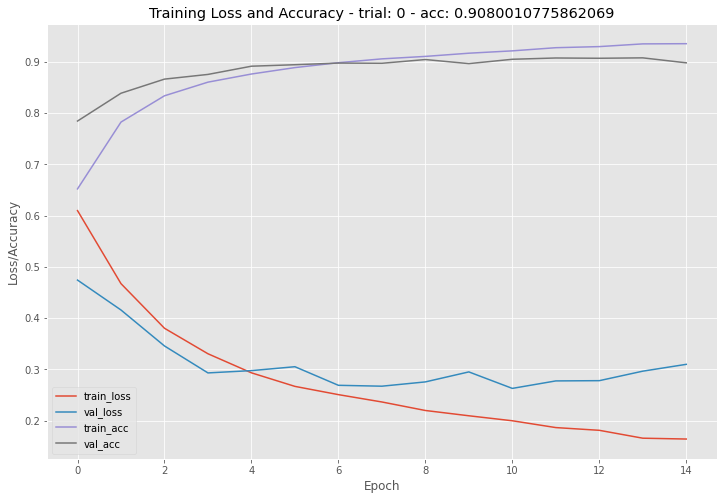

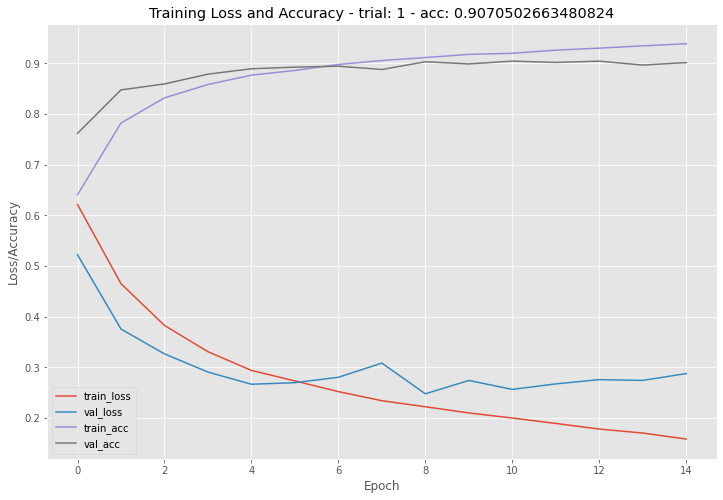

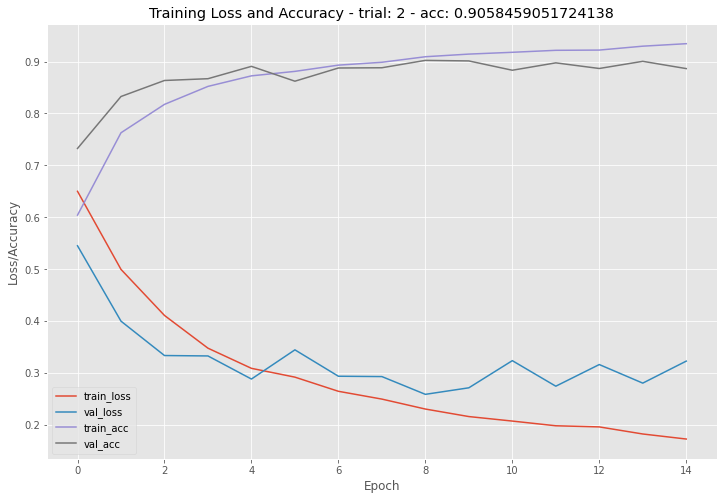

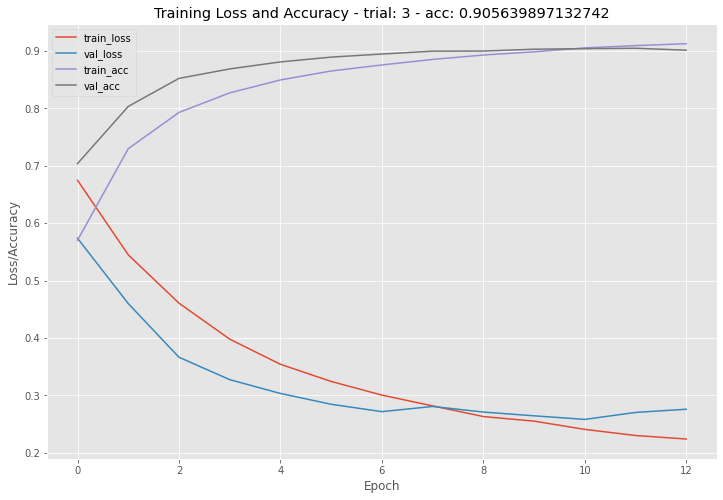

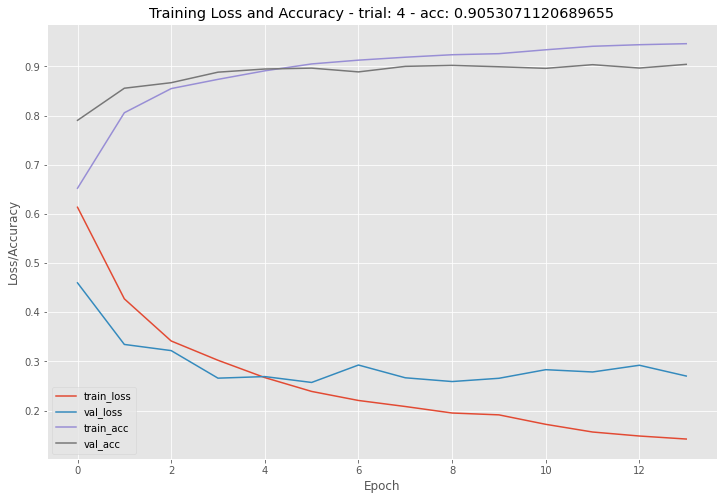

In [ ]:
if not TESTING_DATA_PATH:
  for i, trial in enumerate(sorted_trials[:5]):
    CELL_TYPE = trial.params['CELL_TYPE']
    INPUT_DIM = len(REVIEW.vocab)
    EMBEDDING_DIM = 50
    HIDDEN_DIM = trial.params['HIDDEN_DIM']
    OUTPUT_DIM = 1
    N_LAYERS = trial.params['N_LAYERS']
    DROPOUT = trial.params['DROPOUT']
    PAD_IDX = REVIEW.vocab.stoi[REVIEW.pad_token]

    model = BRNN(CELL_TYPE, 
                  INPUT_DIM, 
                  EMBEDDING_DIM, 
                  HIDDEN_DIM, 
                  OUTPUT_DIM, 
                  N_LAYERS, 
                  DROPOUT, 
                  PAD_IDX)
    pretrained_embeddings = REVIEW.vocab.vectors

    #Initialize the weights of the embedding layer with the GloVe pre-trained embeddings.
    model.embedding.weight.data.copy_(pretrained_embeddings)
    UNK_IDX = REVIEW.vocab.stoi[REVIEW.unk_token]

    #Initialize the <unk> and <pad> tokens to zero
    model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
    model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCELoss()
    model = model.to(device)
    criterion = criterion.to(device)

    N_EPOCHS = trial.params['N_EPOCHS']
    CLIP_VALUE = trial.params['CLIP_VALUE']

    total_train_loss = []
    total_train_acc = []
    total_valid_loss = []
    total_valid_acc = []

    for epoch in range(N_EPOCHS):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, CLIP_VALUE)
        if not TESTING_DATA_PATH:
          valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
            
        total_train_loss.append(train_loss)
        total_train_acc.append(train_acc)
        if not TESTING_DATA_PATH:
          total_valid_loss.append(valid_loss)
          total_valid_acc.append(valid_acc)

        print(f'Epoch: {epoch+1:02}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        if not TESTING_DATA_PATH:
          print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    plot_loss_acc(total_train_loss, total_valid_loss, total_train_acc, total_valid_acc, N_EPOCHS, append_to_title=" - trial: " + str(i) + " - acc: " + str(trial.value))


In [ ]:
if not TESTING_DATA_PATH:
  best_trial_idx = 3
  best_trial = sorted_trials[best_trial_idx]

In [ ]:
if not TESTING_DATA_PATH: 
  print("Best trial:")
  print("  Value: ", best_trial.value)

  print("  Params: ") 
  for key, value in best_trial.params.items():
      print("    {}: {}".format(key, value))

Best trial:
  Value:  0.905639897132742
  Params: 
    CELL_TYPE: GRU
    HIDDEN_DIM: 32
    N_LAYERS: 2
    DROPOUT: 0.6212660301003445
    N_EPOCHS: 13
    CLIP_VALUE: 3


### **Final BRNN model**

In [ ]:
if not TESTING_DATA_PATH:
  # Hyperparameters initialization
  CELL_TYPE = best_trial.params['CELL_TYPE']
  INPUT_DIM = len(REVIEW.vocab)
  EMBEDDING_DIM = 50
  HIDDEN_DIM = best_trial.params['HIDDEN_DIM']
  OUTPUT_DIM = 1
  N_LAYERS = best_trial.params['N_LAYERS']
  DROPOUT = best_trial.params['DROPOUT']
  PAD_IDX = REVIEW.vocab.stoi[REVIEW.pad_token]

  model = BRNN(CELL_TYPE, 
                INPUT_DIM, 
                EMBEDDING_DIM, 
                HIDDEN_DIM, 
                OUTPUT_DIM, 
                N_LAYERS, 
                DROPOUT, 
                PAD_IDX)

In [ ]:
if TESTING_DATA_PATH:
  # Hyperparameters initialization
  CELL_TYPE = 'GRU'
  INPUT_DIM = len(REVIEW.vocab)
  EMBEDDING_DIM = 50
  HIDDEN_DIM = 32
  OUTPUT_DIM = 1
  N_LAYERS = 2
  DROPOUT = 0.6212660301003445
  PAD_IDX = REVIEW.vocab.stoi[REVIEW.pad_token]

  model = BRNN(CELL_TYPE, 
                INPUT_DIM, 
                EMBEDDING_DIM, 
                HIDDEN_DIM, 
                OUTPUT_DIM, 
                N_LAYERS, 
                DROPOUT, 
                PAD_IDX)

In [ ]:
print(model)

BRNN(
  (embedding): Embedding(20002, 50, padding_idx=1)
  (rnn): GRU(50, 32, num_layers=2, dropout=0.6212660301003445, bidirectional=True)
  (dropout): Dropout(p=0.6212660301003445, inplace=False)
  (out): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
pretrained_embeddings = REVIEW.vocab.vectors

#Initialize the weights of the embedding layer with the GloVe pre-trained embeddings.
model.embedding.weight.data.copy_(pretrained_embeddings)
UNK_IDX = REVIEW.vocab.stoi[REVIEW.unk_token]

#Initialize the <unk> and <pad> tokens to zero
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
if not TESTING_DATA_PATH:
  N_EPOCHS = best_trial.params['N_EPOCHS']
  CLIP_VALUE = best_trial.params['CLIP_VALUE']
else:
  N_EPOCHS = 13
  CLIP_VALUE = 3 

total_train_loss = []
total_train_acc = []
total_valid_loss = []
total_valid_acc = []

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, CLIP_VALUE)
    if not TESTING_DATA_PATH:
      valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
        
    total_train_loss.append(train_loss)
    total_train_acc.append(train_acc)
    if not TESTING_DATA_PATH:
      total_valid_loss.append(valid_loss)
      total_valid_acc.append(valid_acc)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    if not TESTING_DATA_PATH:
      print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01
	Train Loss: 0.678 | Train Acc: 55.86%
	 Val. Loss: 0.585 |  Val. Acc: 69.92%
Epoch: 02
	Train Loss: 0.562 | Train Acc: 71.91%
	 Val. Loss: 0.468 |  Val. Acc: 78.82%
Epoch: 03
	Train Loss: 0.463 | Train Acc: 78.75%
	 Val. Loss: 0.370 |  Val. Acc: 84.31%
Epoch: 04
	Train Loss: 0.398 | Train Acc: 82.43%
	 Val. Loss: 0.321 |  Val. Acc: 86.62%
Epoch: 05
	Train Loss: 0.353 | Train Acc: 85.03%
	 Val. Loss: 0.306 |  Val. Acc: 87.36%
Epoch: 06
	Train Loss: 0.321 | Train Acc: 86.74%
	 Val. Loss: 0.288 |  Val. Acc: 88.79%
Epoch: 07
	Train Loss: 0.302 | Train Acc: 87.55%
	 Val. Loss: 0.302 |  Val. Acc: 88.77%
Epoch: 08
	Train Loss: 0.283 | Train Acc: 88.42%
	 Val. Loss: 0.296 |  Val. Acc: 88.90%
Epoch: 09
	Train Loss: 0.266 | Train Acc: 89.23%
	 Val. Loss: 0.277 |  Val. Acc: 89.69%
Epoch: 10
	Train Loss: 0.255 | Train Acc: 89.65%
	 Val. Loss: 0.317 |  Val. Acc: 88.54%
Epoch: 11
	Train Loss: 0.246 | Train Acc: 90.25%
	 Val. Loss: 0.302 |  Val. Acc: 89.36%
Epoch: 12
	Train Loss: 0.232 | T

In [ ]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.264 | Test Acc: 90.50%


### **Scores** 

In [ ]:
#tests the model in the test dataset
#return predictions and true label values in form of lists
def predictions_true_labels(model, test_iterator):
  predictions = []
  true_labels = []

  model.eval()
  with torch.no_grad():
      for batch in test_iterator:
          text, text_length = batch.review
          true_label = batch.rating.reshape(-1, 1)
          pred = model(text, text_length)

          predictions.append(pred)
          true_labels.append(true_label)
  
  predictions = torch.cat(predictions, dim=0).cpu()
  true_labels = torch.cat(true_labels, dim=0).cpu()

  return predictions, true_labels

In [ ]:
predictions, true_labels = predictions_true_labels(model, test_iterator)

In [ ]:
from sklearn.metrics import classification_report

predictions = predictions.ge(.5).view(-1).cpu()
true_labels = true_labels.cpu()

print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      4452
         1.0       0.91      0.90      0.90      4550

    accuracy                           0.90      9002
   macro avg       0.90      0.90      0.90      9002
weighted avg       0.90      0.90      0.90      9002



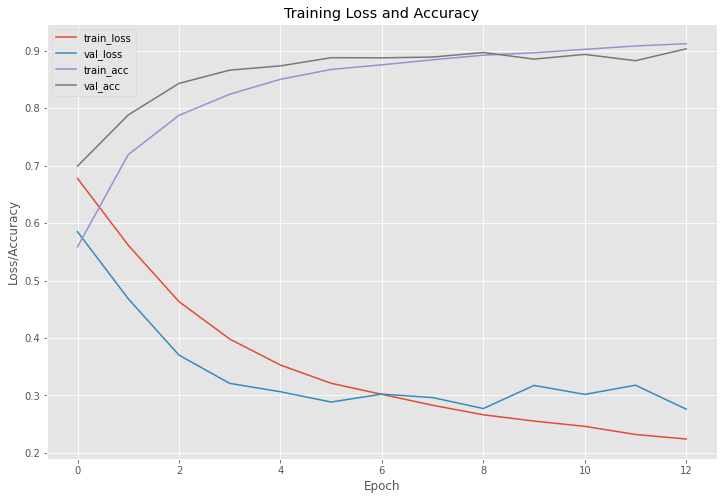

In [ ]:
if not TESTING_DATA_PATH:
  plot_loss_acc(total_train_loss, total_valid_loss, total_train_acc, total_valid_acc, N_EPOCHS)

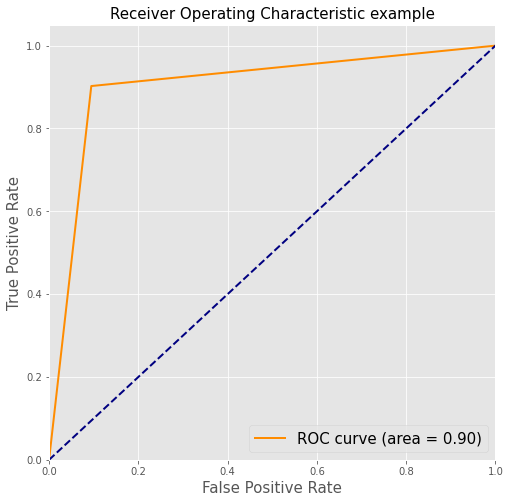

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

predictions = predictions.cpu().detach().numpy()
true_labels = true_labels.cpu().detach().numpy()

true_labels = label_binarize(true_labels, classes=[0, 1])
n_classes = true_labels.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(true_labels[:], predictions[:])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver Operating Characteristic example', fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()